# Modelling of catalogue data
$\texttt{lenstronomy}$ was originally developed to simulate and model imaging data. The modular design allows to model and sample data in catalogue form too. In this notebook, we read in data from the Mahler et al. paper for multiple sources multiply imaged by a galaxy cluster.

In the first step, we read in the necessary data:
- image positions and redshifts
- lens positions

and perform some calculations:
- relative time delays
- lens luminosity and mass

In a second step, we use this data to sample the lens model parameter space. The modelling can also be used if only partial information is available (e.g. no time delays and/or flux ratio measurements) are available.

In a first step, we simulate a quad lens and compute the following mock data products:

- image positions (with astrometric uncertainties)
- relative time delays (with uncertainties)
- relative image brightness (with uncertainties) based on a extended Gaussian surface brighness corresponding to a narrow line emission region.

In a second step, we use this mock data to sample the lens model parameter space (and optionally the quasar source size). The modelling can also be used if only partial information (e.g. no time delays and/or no flux ratio measurements) are available.

The notebook also describes the different possibilities in folding in the positional information in the modeling when the underlying requirement is that the images come from the same source and how to enforce this when evaluating the time delay prediction.

In [30]:
# import the necessary python modules
import astropy
import copy
import corner
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy
import time
import lenstronomy_clusters_functions.clusters_functions
from astropy.cosmology import FlatLambdaCDM

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Util import constants
from lenstronomy.Util import param_util
from lenstronomy.Plots import lens_plot

import lenstronomy_clusters_functions.clusters_functions

%matplotlib inline

## Reading in catalogue data

In [31]:
# important initial values

random.seed(10)
measurement_realization = True  # if True, draws measurement values from the uncertainties, if not, keeps the true value

In [32]:
# mini functions to check if something is a float or not, and to find the value of a float before the decimal point (rounding down)
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

def find_value_before_decimal(list, target_value):
    count = 0
    for decimal in list:
        decimal = float(decimal)
        if math.floor(decimal) == target_value:
            count += 1
    return count

In [33]:
# READING IN AND CONVERTING DATA - LENS PARAMETERS

# reading in the data, just a mess because the file is not normalized
with open('input.par', 'r') as input:
    params = []
    for line in input:
        if line.find(":") != -1 or line.find(" ") != -1:
            # print("Scenario 1")
            if line.find(":") != -1:
                name, value = line.split(":")
            # print(name, '...', value)
            if line.find('\t') != -1:
                # print("tab present:", line)
                line = line.replace('\t', " ")
                line = line.lstrip()
                line = line.rstrip()
                # print(line)
            if line.count(" ") >= 2:
                # print("Scenario 1.1")
                name, value = line.split(" ", 1)
                name = name.strip()
                value = value.lstrip()
                value = value.rstrip()
                value = value.split(" ")
                for x in value:
                    if is_float(x) is True:
                        x = float(x)
                    else:
                        x = x
                # print(name, '...', value)
            else:
                # print("Scenario 1.2")
                name, value = line.split(" ")
                if line.find(":") != -1:
                    name = name.replace(":", " ")
                name = name.strip()
                value = value.lstrip()
                value = value.rstrip()
                # print(name, '...', value)
                if is_float(value) is True:
                    value = float(value)
            params.append([name, value])
        elif line.find(" ") == -1:
            # print("Scenario 3")
            line = line.lstrip()
            line = line.rstrip()
            params.append(line)
            # print(line)
input.close()

input_data_frame = pd.DataFrame(params, columns=["Variable", "Value", "", "", "", "", "", "", "", ""])
# for i in range(len(input_data_frame)):
#     print(input_data_frame.iloc[i])

reference_point = [float(input_data_frame['Value'].iloc[9][1]), float(input_data_frame['Value'].iloc[9][2])]
# [110.82675, -73.454628] for the Mahler paper

In [34]:
## load in the new image data and convert to make it useable
# this reads in the Mahler data on the multiple image systems. Each arc is then sorted, and the refernce ra and dec are recorded in arcsec.
    # The image redshifts are input by hand as listed in the Mahler paper.

#process for data in a .dat file with ' ' as delimiter
with open('arcs.dat', 'r') as file:
    arcs_data = file.read()
lines = arcs_data.splitlines()
arcs_data_deg=[]
for i in range(len(lines)):
    arcs_data_deg.append(lines[i].split(' '))

arcs_data_corr = copy.deepcopy(arcs_data_deg)       # deepcopy fixes the *10 "rounding" error

for i in range(len(arcs_data_corr)):
    for j in range(len(arcs_data_deg[i])-1):
        arcs_data_corr[i][j] = float(arcs_data_deg[i][j])

for i in range(len(arcs_data_corr)):
    arcs_data_corr[i][1] = (arcs_data_corr[i][1] - reference_point[0])*math.cos(reference_point[1])
    arcs_data_corr[i][2] = arcs_data_corr[i][2] - reference_point[1]

arcs_data_arcsec = copy.deepcopy(arcs_data_corr)

# convert to arcsec
for i in range(len(arcs_data_arcsec)):
    arcs_data_arcsec[i][1] = arcs_data_corr[i][1]*3600
    arcs_data_arcsec[i][2] = arcs_data_corr[i][2]*3600

# print('reference point:', reference_point)
# print('degrees from reference point: ', arcs_data_corr)
# print('arcsecs from reference point: ', arcs_data_arcsec)

ra_list = []
dec_list = []
for i in range(len(arcs_data_deg)):
    ra_list.append(arcs_data_deg[i][1])
    dec_list.append(arcs_data_deg[i][2])

x_pos_list = []
y_pos_list = []
for i in range(len(arcs_data_arcsec)):
    x_pos_list.append(arcs_data_arcsec[i][1])
    y_pos_list.append(arcs_data_arcsec[i][2])

# create a list of image ids
num_images=len(arcs_data_arcsec)
image_ids = []
for i in range(num_images):
    image_ids.append(str(arcs_data_arcsec[i][0]))

## caluculate number of sources from image list
images_list = []
sources_list = []
for i in range(len(arcs_data_arcsec)):
    index = find_value_before_decimal(image_ids, i+1)
    if index != 0:
        images_list.append(index)
        sources_list.append(i+1)
total_images = sum(images_list)
num_sources_data = len(sources_list)
images_list = [i for i in images_list if i != 0]

print(total_images)
print(images_list)

# z for the images from the Mahler paper
z_sources_new = [1.449, 1.449, 1.449, 1.3779, 1.3779, 1.3779, 1.9914, 1.9914, 1.9914, 1.9914,
                 2.31, 2.31, 2.31, 1.425, 1.425, 1.425, 1.70, 1.70, 1.70, 5.17, 5.17, 5.17, 
                 14.39, 14.39, 3.01, 3.01, 1.43, 1.43, 1.43, 1.73, 1.73, 1.73, 1.81, 1.81, 
                 1.81, 3.34, 3.34, 3.34, 2.04, 2.04, 2.04, 1.09, 1.09, 2.12, 2.12, 2.12, 1.37, 
                 1.37, 1.37, 1.37, 1.37, 1.37, 2.60, 2.60, 2.60, 3.93, 3.93, 3.93, 2.88, 2.88]

60
[3, 3, 4, 3, 3, 3, 3, 2, 2, 3, 2, 3, 4, 3, 2, 3, 3, 3, 3, 3, 2]


In [35]:
# CLUSTER MEMBER REDSHIFTS

# loading in the redshifts from another source: https://niriss.github.io/smacs0723.html. This is the cluster member redshifts for the galaxies in the list. Need to make sure that each is matched with
    # the correct galaxy in the galcat.cat data, otherwise the lens properties will be incorrect. This file provides z data either spectrcopically or from grism.

with open('redshift_catalog.txt', 'r') as file:
    z_file = file.read()
lines = z_file.splitlines()
z_data=[]
for i in range(len(lines)):
    z_data.append(lines[i].split(' '))

columns=[]
for i in range(len(z_data[2])):
    columns.append(str(z_data[2][i]))


z_data_frame = pd.DataFrame(z_data[3:-1], columns=columns)
z_data_corr = copy.deepcopy(z_data_frame)

# df["col"][row_indexer] = value   -->   # Use `df.loc[row_indexer, "col"] = values`

for i in range(len(z_data_corr)):
    z_data_corr.loc[i, 'RA'] = (float(z_data_corr['RA'].iloc[i]) - reference_point[0])*math.cos(reference_point[1])
    z_data_corr.loc[i, 'DEC'] = float(z_data_corr['DEC'].iloc[i]) - reference_point[1]

z_data_arcsec = copy.deepcopy(z_data_corr)

# convert to arcsec
for i in range(len(z_data_arcsec)):
    z_data_arcsec.loc[i, 'RA'] = z_data_corr['RA'].iloc[i]*3600
    z_data_arcsec.loc[i, 'DEC'] = z_data_corr['DEC'].iloc[i]*3600

print(len(z_data_arcsec))

# this then selects the available data on the spectroscopy for each galaxy. If z_spec is availble, that is used, if not and z_grism is available, that is.
z_cluster_members = []
for i in range(len(z_data_arcsec)):
    z_spec_data = z_data_arcsec['Z_SPEC'].iloc[i]
    z_grism_data = z_data_arcsec['Z_GRISM'].iloc[i]

    if "\"" not in z_spec_data:
        z_cluster_members.append(z_data_arcsec['Z_SPEC'].iloc[i])
    # isinstance(z_spec_data, float) is True:
    elif "\"" not in z_grism_data:
    # z_grism_data is not str:
    # isinstance(z_grism_data, float) is True:
        z_cluster_members.append(z_data_arcsec['Z_GRISM'].iloc[i])
    else:
        z_cluster_members.append(0.0)
print('%s' %(z_cluster_members))

# for i in range(len(z_cluster_members)):
#     if float(z_cluster_members[i]) >= 2.0:
#         print(z_cluster_members[i])

189
['0.3941', '0.3964', '0.7388', '0.8226', '2.1182', '0.7477', '1.9661', '1.9697', '1.9539', '1.3832', '0.3969', '0.4076', '1.2256', '1.4199', '2.0476', '0.3941', '2.5736', '0.9117', '1.9937', '1.244', '1.9826', '2.8132', '0.3958', '1.3713', '0.9127', '1.5626', '0.392', '0.3938', '1.1348', '1.4729', '0.4066', '0.5972', '0.3217', '0.728', '0.3971', '0.3945', '5.275', '1.4745', '0.3813', '2.1558', '0.7455', '0.4023', '2.2095', '1.4503', '0.8578', '1.3782', '2.213', '1.9832', '0.2876', '1.996', '0.4233', '0.3241', '0.3836', '0.3955', '0.3864', '0.3822', '0.5189', '1.3782', '1.085', '0.3787', '1.4874', '1.883', '0.3865', '0.3828', '0.424', '0.3999', '0.3863', '1.4816', '1.7189', '2.463', '0.3901', '1.4503', '1.3722', '1.3808', '0.3844', '1.5079', '1.3782', '0.3872', '3.0994', '0.3829', '0.8261', '1.0563', '0.7469', '1.5013', '0.3932', '0.4018', '1.9774', '2.118', '0.6002', '1.0776', '1.0762', '1.3739', '0.3931', '1.5001', '3.3736', '2.743', '1.2618', '1.8206', '1.3618', '3.0997', '1.2602

In [36]:
# reading in the data from the Mahler galaxy catalog. Formatting is aweful, so a lot of data normalization. Then we get out data on each cluster member's:
    # Galaxy ID, RA, DEC, a, b, theta, apparent magnitude, z. The ra and dec are converted form degrees to arcsec. a and b are used to calculate the 

with open('galcat.cat', 'r') as file:
    gal_cat = file.read()

lines = gal_cat.splitlines()

for i in range(len(lines)):
    lines[i]=lines[i].lstrip('#')
    lines[i]=lines[i].lstrip(str(chr(32)))

gal_data=[]
for i in range(len(lines)):
    gal_data.append(lines[i].split(' '))

# We don't need blank lines, so find them...
str_to_find = ''
Is = []
for i in range(len(gal_data)):
    blank_in_data = np.isin(str_to_find, gal_data[i])
    if blank_in_data == True:
        Is.append(i)
Is.reverse()
# ... and now get rid of them
for i in range(len(Is)):
    row_to_remove = Is[i]
    gal_data.remove(gal_data[row_to_remove])

# Convert the position from deg to arcsec
gal_data_deg = copy.deepcopy(gal_data)

# convert values from strings to floats
for i in range(len(gal_data_deg)):
    for j in range(len(gal_data_deg[i])):
        gal_data_deg[i][j] = float(gal_data[i][j])
# print(gal_data_deg)

# subtract reference point from galaxy positions in degrees
for i in range(len(gal_data_deg)):
    gal_data_deg[i][1] = (gal_data_deg[i][1] - reference_point[0])*math.cos(reference_point[1])
    gal_data_deg[i][2] = (gal_data_deg[i][2] - reference_point[1])
# print(gal_data_corr)

gal_data_corr = copy.deepcopy(gal_data_deg)

# convert coordinates to arcsec
for i in range(len(gal_data_corr)):
    gal_data_corr[i][1] = gal_data_deg[i][1]*3600
    gal_data_corr[i][2] = gal_data_deg[i][2]*3600
# print(gal_data_arcsec)

# make data frame
columns = ['Galaxy ID', 'RA', 'DEC', 'a', 'b', 'theta', 'magnitude', 'z']

gal_data_arcsec = pd.DataFrame(gal_data_corr, columns=columns)
# print(gal_data_arcsec)
print(len(gal_data_arcsec))
print(gal_data_arcsec['theta'].iloc[0])

148
-51.1


In [37]:
# this matching code is used to ensure that the 
# each galaxy in teh galcat file does not have an associated redshift. This is designed to match the galaxies in that file with those in the redshift_catalog file so that we can use the correct redshifts
    # for each of their respecitve galaxies. This uses the ra and dec to find galaxies that match these parameters and returns the relevant indices so that they can be combined into one list. Hopefully
    # I can then plot just these galaxies, which while it will provide fewer constriants, might be more correct to what's in the sky.
    # ... a bit frustraing that the galaxies aren't already labeled identically in each file for easy comparison, or that Mahler just didn't tell us which went with which, but ok I guess.

# the method/test case below works!
# cols = ['A', 'B', 'C']
# df1 = pd.DataFrame([[1, 4, 7], [2, 5, 8], [3, 6, 9]], columns=cols)
# df2 = pd.DataFrame([[3, 5, 1], [9, 1, 8], [5, 4, 7], [2, 6, 0], [4, 3, 1]], columns=cols)
# for k, v in df1['A'].items():
#     # print(k, v)
#     for key, value in df2['A'].items():
#         if float(v) == float(value):
#             print('%s matches %s'%(v, value))
#         else:
#             print('%s does not match %s'%(v, value))

z_options = []
gal_options = []
for i in range(len(z_data_arcsec)):
    z_options.append([z_data_arcsec['ID'].iloc[i], z_data_arcsec['RA'].iloc[i], z_data_arcsec['DEC'].iloc[i]])
for i in range(len(gal_data_arcsec)):
    gal_options.append([gal_data_arcsec['Galaxy ID'].iloc[i], gal_data_arcsec['RA'].iloc[i], gal_data_arcsec['DEC'].iloc[i]])

z_len = len(z_options)
gal_len = len(gal_options)

matched_gals = []
unmatched_index = []
unmatched_z = z_options
unmatched_gal = gal_options

for i in range(z_len):
    for j in range(gal_len):
        if math.isclose(z_options[i][1], gal_options[j][1], rel_tol=0.01):   ## relax this tolerance a bit
            print('%s, %s: %s matches %s'%(i, j, z_options[i][1], gal_options[j][1]))
            if math.isclose(z_options[i][2], gal_options[j][2], rel_tol=0.01):    ## and here too
                print('%s, %s: %s matches %s'%(i, j, z_options[i][2], gal_options[j][2]))
                matched_gals.append([i, z_options[i], j, gal_options[j]])

                # gal_options.remove(gal_options[j])
                # gal_len -= 1
                # j -= 1
            else: 
                # print('%s: %s does not match %s'%(i, z_options[i][2], gal_options[j][2]))
                unmatched_index.append(i)
                break
            # matched_gals.append([i, z_options[i], j, gal_options[j]])
        else:
            print('%s: %s does not match %s'%(i, z_options[i][1], gal_options[j][1]))
            # or pass
unmatched_gals_index = list(set(unmatched_index))
unmatched_gals_index.sort()

# match_index = []
# for i in range(len(matched_gals)):
#     match_index.append(matched_gals[i][0])
# set_matched = set(match_index)
# # print(set_matched)

# # print(unmatched_index)
# # print(matched_gals)

# # matched_gals.sort()
# # for i in range(len(matched_gals)):
# #     print(matched_gals[i])
# # print(len(unmatched_gals_index), unmatched_gals_index)

# # for i in range(len(matched_gals)):
# #     print(matched_gals[i][0])

# set_unmatched = set(unmatched_index)
# # print(set_unmatched)

# checks = []
# check = set(set_unmatched).intersection(set(set_matched))
# # print(check)

for i in range(len(matched_gals)):
    print('gal_data_arcsec ID: %s, z_data_arcsec ID: %s' %(matched_gals[i][0], matched_gals[i][2]))

0: 40.99407818494283 does not match -11.28084356039193
0: 40.99407818494283 does not match 44.81321822663787
0: 40.99407818494283 does not match -44.524691857738794
0: 40.99407818494283 does not match -0.041686226860088195
0: 40.99407818494283 does not match 34.281678039568405
0: 40.99407818494283 does not match 74.6985723979199
0: 40.99407818494283 does not match -108.21285681478709
0: 40.99407818494283 does not match 11.192620822423294
0: 40.99407818494283 does not match 28.94295704903317
0: 40.99407818494283 does not match -35.46462304321816
0: 40.99407818494283 does not match -38.96718372058935
0: 40.99407818494283 does not match -30.30706672413137
0: 40.99407818494283 does not match -63.25570312561742
0: 40.99407818494283 does not match 137.81597687782676
0: 40.99407818494283 does not match 134.9439531538731
0: 40.99407818494283 does not match 10.831340189648282
0: 40.99407818494283 does not match -116.4596509392962
0: 40.99407818494283 does not match 1.3949155345463158
0: 40.9940

In [38]:
# Image properties
# this groups the images according to the sources that they came from, each list contains lists of the associated image ID's, positions, and redshifts. Used for plotting purposes.

grouped_ids = []
grouped_x_pos = []
grouped_y_pos = []
grouped_z_sources = []

cutoff = 0
for i in range(num_sources_data):
    ids_temp = []
    images_x_temp = []
    images_y_temp = []
    z_temp = []
    for j in range(images_list[i]):
        ids_temp.append(image_ids[j+cutoff])
        images_x_temp.append(x_pos_list[j+cutoff])
        images_y_temp.append(y_pos_list[j+cutoff])
        z_temp.append(z_sources_new[j+cutoff])
    cutoff += images_list[i]
    grouped_ids.append(ids_temp)
    grouped_x_pos.append(images_x_temp)
    grouped_y_pos.append(images_y_temp)
    grouped_z_sources.append(z_temp)

# print(grouped_ids[15])
# print(grouped_x_pos)
# print(grouped_y_pos)
# print(grouped_z_sources)

In [39]:
# Input for lens properties
# This includes the assumed cosmology, the lens parameters for each sie member galaxy, and the nfw dark matter halo

import astropy.units as u

# z_lens = 0.3877
z_lens = float(input_data_frame['Value'].iloc[50][0])

# source properties
z_source_convention= 1.5
# the redshifts of lens and source and the cosmology is only used when predicting the relative time delays between the images

# I don't know if I need this...
# calculate this later in a more reliable way, I think
# calculating sigma_0 (velocity dispersion) for the images ??  Uses the velocity dispersion, Ra, and Rs of the main deflector to caluclate the sigma_0's of the member galaxies
v_disp = float(input_data_frame['Value'].iloc[68][0])
Ra = float(input_data_frame['Value'].iloc[66][0])
Rs = float(input_data_frame['Value'].iloc[67][0])

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.) # H_0 {km/s/Mpc}, omega_0 (= (ρ / ρ_critical) where ρ is the actual density of the universe and ρ_critical is the critical density. ), Omega_b (Baryon density today)
lensCosmo = LensCosmo(cosmo=cosmo, z_lens=z_lens, z_source=z_source_convention)

# for the astropy calculation of the luminosity distances or the cluster member galaxies
astro_cosmo = FlatLambdaCDM(H0=70*u.km / u.s / u.Mpc, Tcmb0=2.725*u.K, Om0=0.3)

# make class instances for a chosen lens model type. Chose a lens model
lens_model_list = []
for i in range(len(gal_data_arcsec)):
    lens_model_list.append('PJAFFE_ELLIPSE_POTENTIAL')
lens_model_list.append('NFW_ELLIPSE_CSE')

# [    "PJAFFE_ELLIPSE_POTENTIAL", 'SIE'
#     "NFW_ELLIPSE_CSE"]           # 'EPL', 'SHEAR', "SIS/SIE"]

# make instance of LensModel class. Only one here, the shifting of the sources will happen in the computing bit further down in this block
lensModel = LensModel(lens_model_list=lens_model_list, cosmo=cosmo, z_lens=z_lens, z_source_convention=z_source_convention, z_source=z_sources_new[0])

# we require routines accessible in the LensModelExtensions class, then make instance of LensEquationSolver to solve the lens equation
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
lensEquationSolver = LensEquationSolver(lensModel=lensModel)

# make choice of lens model
# we chose a source position (in units angle)

In [40]:
phi = 0.1
gamma = 0.1
gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.1)
# chose the data where the lens is centered at (0,0). First model in list --> subtract 19 from the values

# calculate the eccentricities in a way that matches lenstronomy's definitions. Need two e's because its a 3D ellipsoid, not a flat ellipse?
angle_rads=[]
qs = []
eccentricities = []
e1s = []
e2s = []
for i in range(len(gal_data_arcsec)):
    angle_rad = (gal_data_arcsec['theta'].iloc[i])*(math.pi/180)             # is 'theta' the correct value to use? input.par has 'angle_pos', which is defined below?
    # for this, 'theta' is defined as: ellipticity of the matter density
    q = ((gal_data_arcsec['b'].iloc[i])/(gal_data_arcsec['a'].iloc[i]))
    ecc = (1-q)/(1+q)
    e1 = float(ecc * (math.cos(2*angle_rad)) * 0.5)
    e2 = float(ecc * (math.sin(2*angle_rad)) * 0.5)

    angle_rads.append(angle_rad)
    qs.append(q)
    eccentricities.append(ecc)
    e1s.append(e1)
    e2s.append(e2)

nfw_angle_rad = (float(input_data_frame['Value'].iloc[65][0]))*(math.pi/180)  # this should be based on the 'angle_pos' value, not the 'theta' value. Is there something similar for the member galaxies?
nfw_q = float(input_data_frame['Value'].iloc[64][0]) # check this value
nfw_ecc = (1-nfw_q)/(1+nfw_q)
nfw_e1 = float(nfw_ecc * (math.cos(2*nfw_angle_rad)) * 0.5)
nfw_e2 = float(nfw_ecc * (math.sin(2*nfw_angle_rad)) * 0.5)    # check the orientation

print('q: %s, ecc: %s, e1: %s, e2: %s' %(nfw_q, nfw_ecc, nfw_e1, nfw_e2))
# print(nfw_angle_rad)
# print(qs)

# 'theta' is definied as from the horizontal (E) upwards towards N
# 'angle_pos': Set the position angle of the potential distribution expressed in degree (90° relative to PA). It corresponds to the direction of the semi-major axis of the iso-potential counted from the horizontal axis, counterclockwise.

# units_coordinates_parameter_definitions.ipynb

q: 0.161, ecc: 0.7226528854435831, e1: 0.18932996344052383, e2: 0.307751463284245


In [41]:
# kwargs_lens

kwargs_lens = []

# Calculating the mass-luminosity scaling. # the paper cited by Mahler sets alpha = -1.25 and L_star = 3*10**10 L_sun. # L_sun =  3.8 x 10**26 watts = 3.8 x 10**33 ergs/sec = 10**26 joules/sec
grav = (scipy.constants.G) * 10**(-9)                       # m**3/(kg*s**2), gravitational constant

# r0 = []                   # core radius
# r0_star = []              # core radius of a typical milky way-type galaxy
# rt = 0                    # truncation radius
Rt_star = 6.171*10**20  #   # m, 20 now, 30 kpc = 9.257*10**20 m, truncation radius of a typical, mily way-type galaxy
Rt_star_kpc = 20

ms = gal_data_arcsec['magnitude']   # apparent magniudes of the lenses
M_sun = 4.83                # absolute magnitude of the sun
M_mw = -20.6
M_andromeda = -21.5 # approximate

L_sun = 3.8*10**26          # watts, luminosity of the sun    = 3.8*10**33 ergs/sec = 10**26 joules/sec
L_mw = float(L_sun * 10**(0.4*(M_sun-M_mw)))  # this equation works!
L_andromeda = (2.6*10**10)*L_sun
L_star = 3*10**10 * L_sun   # watts, luminosity of a typical, milky way-type galaxy     # central galaxies in halos at the upper end of the selected mass range??

L_ratio_star = L_star/L_mw
L_ratio_andromeda = L_andromeda/L_mw
L_ratios = []

sigma_v_star = 160          # km/s, central Velocity Dispersion of a typical, milky way-type galaxy
mass_star = 6*(10**42)      # kg, mass of a milky way type galaxy
alpha = 0.8                 # tunes the size of the galaxy halo

D_l_andromeda = 765000
D_l_Mpcs = []               # luminosity distance in Mpc
D_l_pcs = []                # luminosity distance in pc

Ms = []
Ls = []                     # watts, luminosity of the galaxy

sie_sigma_vs = []
sie_theta_Es = []
dPIED_sigma_0s = []

# base calculations for a mw type galalxy
andromeda_sigma_v = sigma_v_star * (L_andromeda/L_star)**(0.25)  # should be 160
andromeda_theta_e = lensCosmo.sis_sigma_v2theta_E(andromeda_sigma_v)

print(andromeda_sigma_v, andromeda_theta_e)

y_ints = np.logspace(1.69897, 2.602, 100, endpoint=True)
                     #50, 400, endpoint=True)
x_ints = np.linspace(-15, -23, 100, endpoint=True)
fj_dict = {'Mag': [x_ints], 'V_disp': [y_ints]}
fj_pairs = pd.DataFrame(data=fj_dict)
# for i in range(len(y_ints)-1):
#     i += 1
#     update = {'%s' %(x_ints[i]): y_ints[i]}
#     faber_jackson_pairs = faber_jackson_pairs | update
y_int_star = {}
# print(x_ints)
# print(fj_pairs)


# newValue= -21.5
# x_int_andromeda, y_int_andromeda = min(fj_pairs['Mag'].items(), key=lambda x: abs(value - newValue))
# # fj_pairs.loc[fj_pairs['Mag'.isclose(-21.5)]]   ### fix this!! then get it to essentially scale with the magnitude, so we search for the magnitude closest to the one of the galaxy we are looking at, then use it as a reference for the subtraction for the calculation
#                                                                     # we don't need one for each, just one as a reference for the reference galaxy_star
# print(x_int_andromeda, y_int_andromeda)





################################################################### this is where the problem starts ###################################################################

# can convert from luminosity to velocity dispersion to einstein radius. Needs assumption that the galaxy is SIS/SIE, for each galaxy:
# lensCosmo: sis_sigma_v2theta_E (or reverse sis_theta_E2sigma_v) function. 
# for a typical galaxy, using the Faber–Jackson relation, sigma_v scales as L**(0.25 - 0.5). y-intercept is ~190 for a mw-type galaxy with an absolute magnitude of -20

# be careful that the L_sun is in a specific band. Expect scaling has to do with L)star, witha  typical galaxy. Don't have to convert specifically
# the subtraction should be for the value at the magntiude of the reference L

for i in range(len(gal_data_arcsec)):
    D_l_Mpc = astro_cosmo.luminosity_distance(z_cluster_members[i])   # this is in units of MPC
    D_l_Mpcs.append(D_l_Mpc)
    D_l_pc = float(D_l_Mpc / u.Mpc * (10**6))               # convert to pc for the absolute magnitude calculation
    D_l_pcs.append(D_l_pc)                                  # --> *(3.086*(10**19)) to m
    M = float(ms.iloc[i] - 5*(math.log(D_l_pc, 10)) + 5)    # this gives M around -23. Is the equation I've most commonly seen for calculating M    
    Ms.append(M)
    # convert magnitude to luminosity, use Milky Way as a reference:
    L = float(L_mw * 10**(0.4*(M_mw-Ms[i])))                # L = L_sun * 10**((M_sun-Mags.iloc[i])/2.5) # L = L_sun * 10**((4.83-M[i])/2.5)
    Ls.append(L)
    L_ratio = float(L/L_mw)
    sie_sigma_v = float(sigma_v_star * (Ls[i]/L_star)**(0.25) - 65)  #- y_int # km/s # check these values in literature. Check for prefactors, and that it is scaling with the appropriate number of starts (~10 billion stars in the MW)
    sie_theta_E = float(lensCosmo.sis_sigma_v2theta_E(sie_sigma_v))  # arcsec
    dPIED_sigma_0 = float(lensCosmo.vel_disp_dPIED_sigma0(vel_disp=sie_sigma_v, Ra=float(gal_data_arcsec['a'].iloc[i]), Rs=Rt_star))   ## Ra is the core radius, Rs is the truncation radius
    L_ratios.append(L_ratio)
    sie_sigma_vs.append(sie_sigma_v)
    sie_theta_Es.append(sie_theta_E)
    dPIED_sigma_0s.append(dPIED_sigma_0)

print('z cluster members: %s, \nD_l_Mpc: %s, \nD_l_pc: %s' %(z_cluster_members, D_l_Mpcs, D_l_pcs))
# print('Apparent m: %s' %(ms))
print('Absolute M: %s' %(Ms))
print('Luminosities: %s' %(Ls))
print('L ratios to MW: %s' %(L_ratios))
# print('As: %s \nBs: %s' %(As, Bs))
print('sigma_vs: %s, \ntheta_es: %s' %(sie_sigma_vs, sie_theta_Es))
print('sigma0: %s' %(dPIED_sigma_0s))


# solve for the mass using the relationshihp found in  ## Natarajan & Kneib 1997 ## M_L_ratio = (12 * (sigma0_star/240)**2)*(Rt_star/30)*( (L/L_star)**(alpha - 0.5)) # = T
masses = [] # milky way-masses, masses of each member galaxy
massV2 = []
mw_mass = 1.5*10**12 # solar masses, mass of the milky way

for i in range(len(gal_data_arcsec)):
    mL_scaling_relationship = (9/(2*grav))*((sigma_v_star)**2)*(Rt_star*(Ls[i]/L_star)**(0.5 + alpha)) # = (2*(math.pi))*Sigma0*r0*rt = 9/(2*G) * (sigma0)**2 * rt
    m_L_scaling_relationship = (9/(2*grav)) * (dPIED_sigma_0s[i])**2 * Rt_star
    masses.append(mL_scaling_relationship)    # closer to kg, mass of the given galaxy
    massV2.append(m_L_scaling_relationship)
print('Mass: %s' %(masses))
print('Mass v2: %s' %(massV2))

# see nfw_physical2angle --> outputs Rs angle and alpha Rs. See google slides 1/27/25
nfw_mass = 10**14.5 # solar masses, mass of a galaxy cluster's halo
concentration = 10 # ratio of r200 to Rs
nfw_Rs, nfw_alpha_Rs = lensCosmo.nfw_physical2angle(nfw_mass, concentration)
nfw_sigma_v = float(input_data_frame['Value'].iloc[68][0])
# print('Rs: %s, alpha_Rs: %s' %(nfw_Rs, nfw_alpha_Rs))

mass_scaling_list = []
for i in range(len(gal_data_arcsec)):
    kwargs_lens.append({'sigma0': dPIED_sigma_0s[i], "e1": e1s[i], "e2": e2s[i], 'Ra': float(gal_data_arcsec['a'].iloc[i]), 'Rs': Rt_star_kpc, 'center_x': float(gal_data_arcsec['RA'].iloc[i]), "center_y": float(gal_data_arcsec['DEC'].iloc[i])})
                        # SIS/SIE: "theta_E": sie_theta_Es[i], "e1": e1s[i], "e2": e2s[i], "center_x": gal_data_arcsec['RA'].iloc[i], "center_y": gal_data_arcsec['DEC'].iloc[i]})
                        #                   ^ sie_theta_Es[i] or 0.2 as a rough estimate   "gamma": 2
    mass_scaling_list.append(1)
kwargs_lens.append({"Rs": nfw_Rs, "alpha_Rs": nfw_alpha_Rs, "e1": nfw_e1, "e2": nfw_e2, "center_x": float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])})
mass_scaling_list.append(False) # Rs is the transition radius from 1 to 3 power law (arcsec), alpha Rs is the defelction angle at that radius
            #     [{"sigma0": sigma_0, "Ra": float(input_data_frame['Value'].iloc[66][0]), "Rs": float(input_data_frame['Value'].iloc[67][0]), "e1": float(input_data_frame['Value'].iloc[64][0]), "e2": 0.0, "center_x": float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])},
            #     {"Rs": float(input_data_frame['Value'].iloc[66][0]), "alpha_Rs": 0.5, "e1": float(input_data_frame['Value'].iloc[64][0]), "e2": 0.0, "center_x": float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])}]

# Definitions:
# dPIED
    # :param sigma0: sigma0/sigma_crit (see class documentation above)
    # :param Ra: core radius (see class documentation above)
    # :param Rs: transition radius from logarithmic slope -2 to -4 (see class documentation)
    # :param e1: eccentricity component in x-direction
    # :param e2: eccentricity component in y-direction
    # :param center_x: center of profile
    # :param center_y: center of profile

# NFW:
#     :param Rs: turn over point in the slope of the NFW profile in angular unit
#     :param alpha_Rs: deflection (angular units) at projected Rs
    # :param e1: eccentricity component in x-direction
    # :param e2: eccentricity component in y-direction
#     :param center_x: center of halo (in angular units)
#     :param center_y: center of halo (in angular units)

# we have the {angular coordinate?, the ellipticity (x/y, diagonal), gamma is how spread out the light is from the central point (larger # = smaller), position of the center of the lens (x, y)}, then the two gammas, which are the cartesian shears based on the given phi (angle)
# gamma = - power law slope of the lens profile. 2 = isothermal, goes as r^-2

154.37714535523816 0.44842897139185117
z cluster members: ['0.3941', '0.3964', '0.7388', '0.8226', '2.1182', '0.7477', '1.9661', '1.9697', '1.9539', '1.3832', '0.3969', '0.4076', '1.2256', '1.4199', '2.0476', '0.3941', '2.5736', '0.9117', '1.9937', '1.244', '1.9826', '2.8132', '0.3958', '1.3713', '0.9127', '1.5626', '0.392', '0.3938', '1.1348', '1.4729', '0.4066', '0.5972', '0.3217', '0.728', '0.3971', '0.3945', '5.275', '1.4745', '0.3813', '2.1558', '0.7455', '0.4023', '2.2095', '1.4503', '0.8578', '1.3782', '2.213', '1.9832', '0.2876', '1.996', '0.4233', '0.3241', '0.3836', '0.3955', '0.3864', '0.3822', '0.5189', '1.3782', '1.085', '0.3787', '1.4874', '1.883', '0.3865', '0.3828', '0.424', '0.3999', '0.3863', '1.4816', '1.7189', '2.463', '0.3901', '1.4503', '1.3722', '1.3808', '0.3844', '1.5079', '1.3782', '0.3872', '3.0994', '0.3829', '0.8261', '1.0563', '0.7469', '1.5013', '0.3932', '0.4018', '1.9774', '2.118', '0.6002', '1.0776', '1.0762', '1.3739', '0.3931', '1.5001', '3.3736', '2

In [42]:
# # baby test of the luminosity distance and theta_e calculation

# # for the astropy calculation of the luminosity distances or the cluster member galaxies
# astro_cosmo = FlatLambdaCDM(H0=70*u.km / u.s / u.Mpc, Tcmb0=2.725*u.K, Om0=0.3)

# D_l_Mpc_mw = astro_cosmo.luminosity_distance(0)   # this is in units of MPC, need to make it m!!
# D_l_pc_mw = D_l_Mpc_mw / u.Mpc * 1000000
# # (3.086*(10**19))
# print('z_lens: %s \nD_l_Mpc: %s \nD_l_pc %s' %(z_lens, D_l_Mpc_mw, D_l_pc_mw))

# M_mw = -20.6

# # convert magnitude to luminosity:
# L_mw = L_sun * 10**(0.4*(M_sun-M_mw))  # this equation works!
# print('L_mw: %s' %(L_mw))
# # sie_sigma_v_mw = (1/(5**(0.5)))*((grav*mass_star)**0.5)*((4*math.pi*B)**0.25) *(L_mw/L_star)**(0.25) 
# sie_sigma_v_mw = (L_mw/L_sun)**(0.25)
# sie_theta_E_mw = lensCosmo.sis_sigma_v2theta_E(sie_sigma_v_mw)
# print('sigma_vs: %s, \ntheta_es: %s' %(sie_sigma_v_mw, sie_theta_E_mw))

In [43]:
# use image positions and calculate their (finite) magnifications
x_imgs = []
y_imgs = []
mag_infs = []
source_sizes_pc = []
source_sizes_arcsec = []
mag_finites = []
t_days = []

D_s = lensCosmo.ds      # angular distance
print(D_s)

# we compute the finite magnification by rendering a grid around the point source position and add up all the flux coming from the extended source in this window
window_size = 0.1  # units of arcseconds
grid_number = 100  # supersampled window (per axis)

for i in range(num_sources_data):
    # x_sources.append(random.uniform(-0.01, 0.01))
    # y_sources.append(random.uniform(-0.01, 0.01))
    # lensEquationSolver.change_source_redshift(z_source=z_sources_new[i])  # here is where we change the redshift
    # x_img_temp, y_img_temp = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens, sourcePos_x=x_sources[i], sourcePos_y=y_sources[i], solver="lenstronomy", min_distance=0.02, search_window=20)

    x_img_temp = grouped_x_pos[i]
    y_img_temp = grouped_y_pos[i]
    x_imgs.append(x_img_temp)
    y_imgs.append(y_img_temp)

    mag_inf_temp = lensModel.magnification(x_imgs[i], y_imgs[i], kwargs_lens)
    mag_infs.append(mag_inf_temp)

    source_size_pc_temp = random.randrange(0, 15)
    source_sizes_pc.append(source_size_pc_temp)
    source_size_arcsec_temp = source_sizes_pc[i] / 10**6 / D_s / constants.arcsec
    source_sizes_arcsec.append(source_size_arcsec_temp)

    mag_finite_temp = lensModelExtensions.magnification_finite(x_pos=x_imgs[i], y_pos=y_imgs[i], kwargs_lens=kwargs_lens, source_sigma=source_sizes_arcsec[i], window_size=window_size, grid_number=grid_number)
    mag_finites.append(mag_finite_temp)
    
    t_days_temp = lensModel.arrival_time(x_imgs[i], y_imgs[i], kwargs_lens)
    t_days.append(t_days_temp)

1745.5423064934434


## Add plots here to compare to the Mahler paper

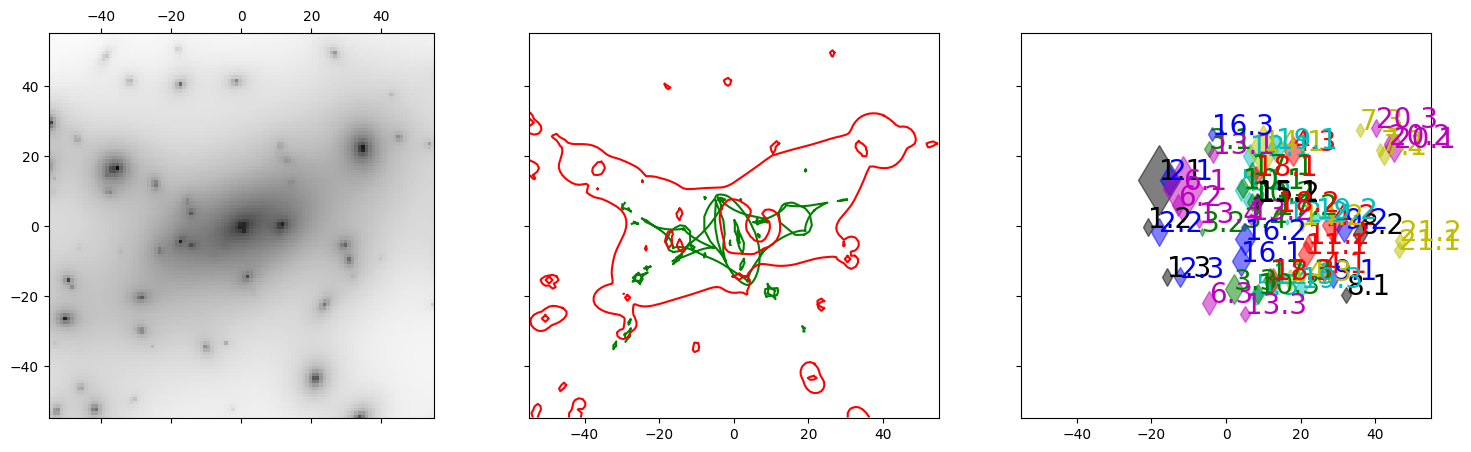

In [44]:
# little ellipse plotting function!
def plot_ellipse(x_cent, y_cent, width, height, angle, ax=None, **kwargs):
    """Plot an ellipse using 'matplotlib.pyplot.plot'."""
    if ax is None:
        ax = plt.gca()

    t = np.linspace(0, 2 * np.pi, 100)
    x = width / 2 * np.cos(t)
    y = height / 2 * np.sin(t)

    # Rotate the ellipse
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    x, y = np.dot(R, np.array([x, y]))

    # Translate the ellipse to the specified center
    x += x_cent
    y += y_cent

    plt.plot(x, y, **kwargs)

# Create figure and axes
# f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
f, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# print(len(gal_data_arcsec))
#Name_list = None # this line is the default, replace none with a list of strings (ex below) to have custom labels
Name_list = [["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"], [".1", ".2", ".3", ".4", ".5", ".6", ".7", ".8", ".9", ".10"]] # if using a custom Name_list, insert:  name_list=Name_list[i]  into the list of parameters for plotting.
num_Names = len(Name_list)
# index is used to for labeling, default is None. If looping over multiple sources, insert:  index=i  into the list of parameters for plotting. 
color_list = ['k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y'] # should be at least as long as the number of sources


# Define ellipse parameters
gals = []
for i in range(len(gal_data_arcsec)):                                                                                                                           # angle in degrees
    gals.append({"xy":(gal_data_arcsec['RA'].iloc[i], gal_data_arcsec['DEC'].iloc[i]), "width":gal_data_arcsec['a'].iloc[i], "height":gal_data_arcsec['b'].iloc[i], "angle":gal_data_arcsec['theta'].iloc[i]})

# # Plot the lenses
# for i in range(len(gals)):
#     #print(gals[i]['xy'][0], gals[i]['xy'][1], gals[i]['width'], gals[i]['height'], gals[i]['angle'])
#     plot_ellipse(gals[i]['xy'][0], gals[i]['xy'][1], gals[i]['width'], gals[i]['height'], angle=gals[i]['angle'], ax=ax, color='k', marker='.')


# for i in range(num_sources_data):
# lensModel.change_source_redshift(z_source=grouped_z_sources[20][0])
# lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=grouped_x_pos[20], images_y=grouped_y_pos[20], 
#                               mag_images=mag_finites[20], index=20, color_value=color_list[20], name_list=Name_list[0],  # [i] for multiple lists, [0] for first one, etc.
#                               point_source=True, images_from_data=True, with_caustics=False, numPix=110, deltaPix=1.0, # this gives the correct scaling! guess it's just in relation to the input units
#                               fontsize=5    # center_x=reference_point[0], center_y=reference_point[1], numPix=250, deltaPix=0.01,
#                               )
                            # with_convergence=False removes the lens masses
                            # with_caustics=False removes the critical curve and caustic lines
                            # images_from_data=True allows you to input lists of multiple image systems directly from data. If False, images_x and images_y must both = None
#     # f.show()

# for i in range(num_sources_data):
#     if any(x < z_limit for x in grouped_z_sources[i]):
#     else:
#       print('%s was outside the z_limit' %(grouped_z_sources[i]))
#       pass

lensModel.change_source_redshift(z_source=grouped_z_sources[20][0])
lens_plot.lens_model_plot(ax[0], lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=None, images_y=None, 
                              mag_images=None, index=20, color_value=color_list[20], name_list=Name_list[0], point_source=True,
                              images_from_data=False, with_caustics=False, numPix=110, deltaPix=1.0, with_convergence=True,
                              fontsize=5
                            )

lens_plot.lens_model_plot(ax[1], lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=None, images_y=None, 
                              mag_images=None, index=20, color_value=color_list[20], name_list=Name_list[0], point_source=True,
                              images_from_data=False, with_caustics=True, numPix=110, deltaPix=1.0, with_convergence=False,
                              fontsize=5
                            )
for i in range(num_sources_data):
        lens_plot.lens_model_plot(ax[2], lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=grouped_x_pos[i], images_y=grouped_y_pos[i], 
                              mag_images=None, index=i, color_value=color_list[i], name_list=Name_list[1], point_source=True,
                              images_from_data=True, with_caustics=False, numPix=110, deltaPix=1.0, with_convergence=False,
                              fontsize=5
                            )
# Show the plot
plt.show()

# kappa = lens.kappa(x_grid_rot, y_grid_rot, kwargs_lens)

C:\Users\earth\AppData\Local\Temp\ipykernel_9276\61372698.py:42: RuntimeWarning: divide by zero encountered in log10
  ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')


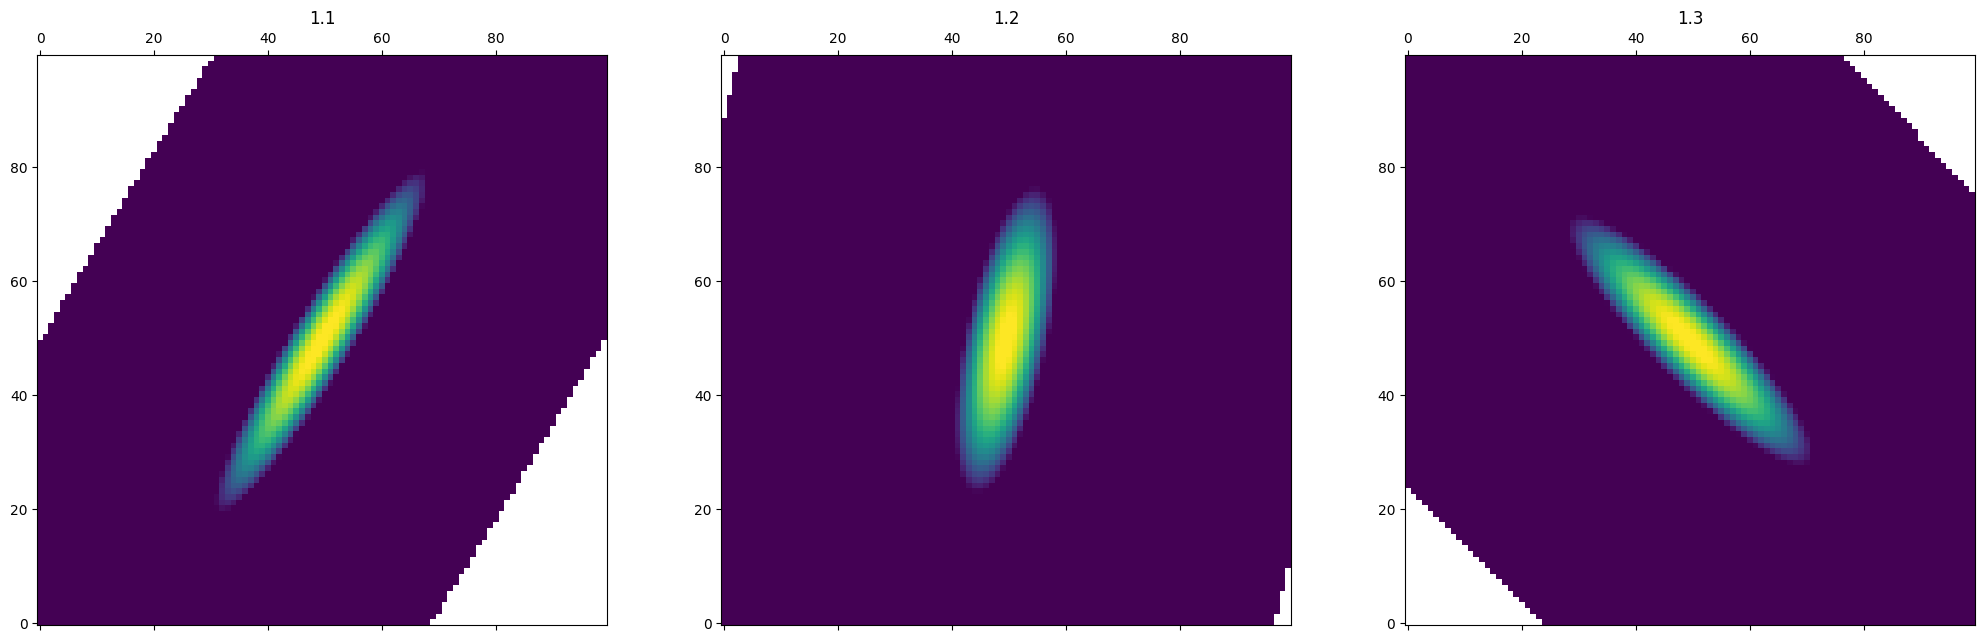

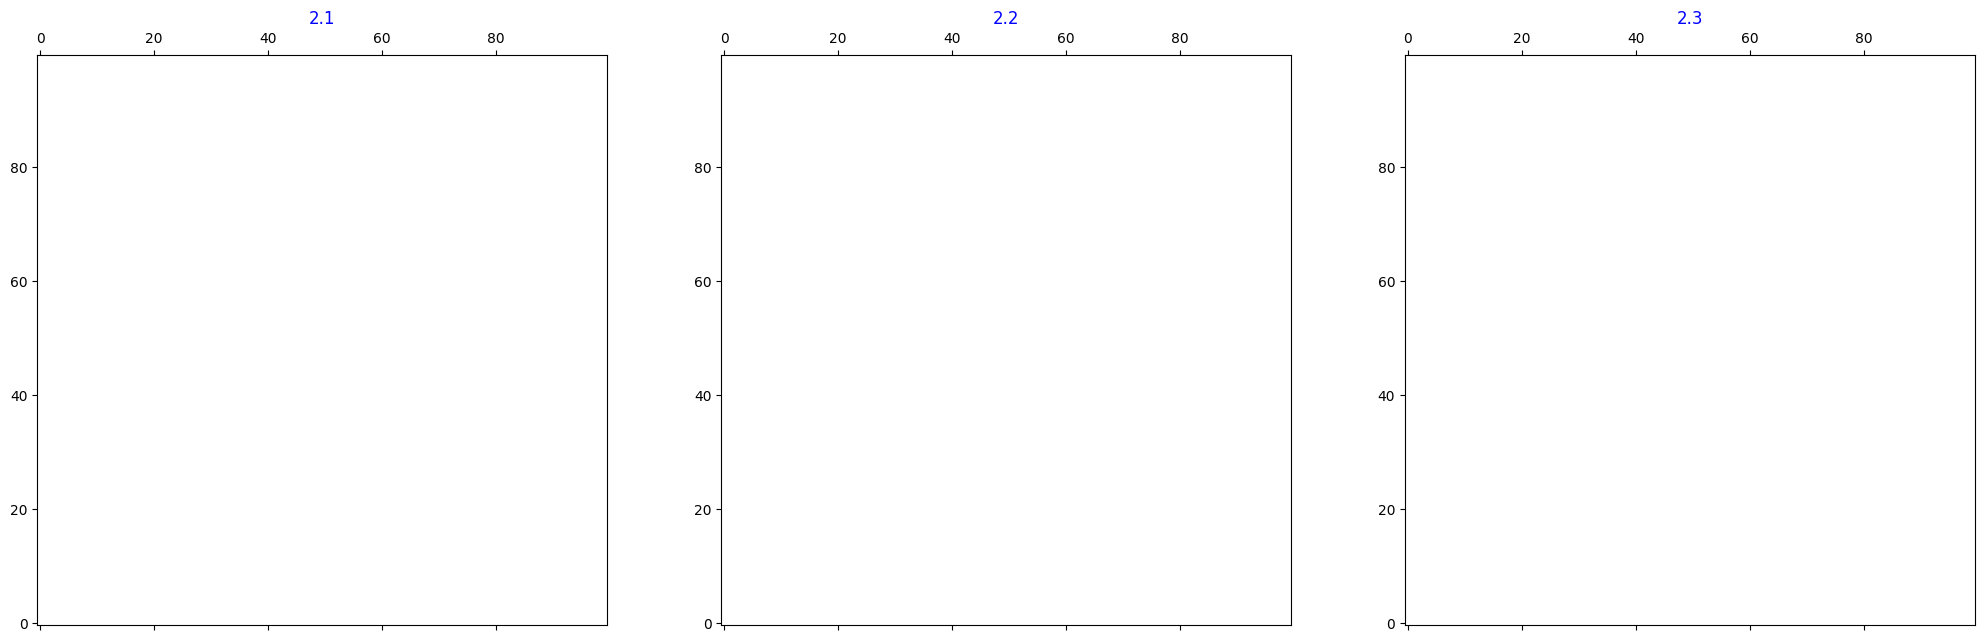

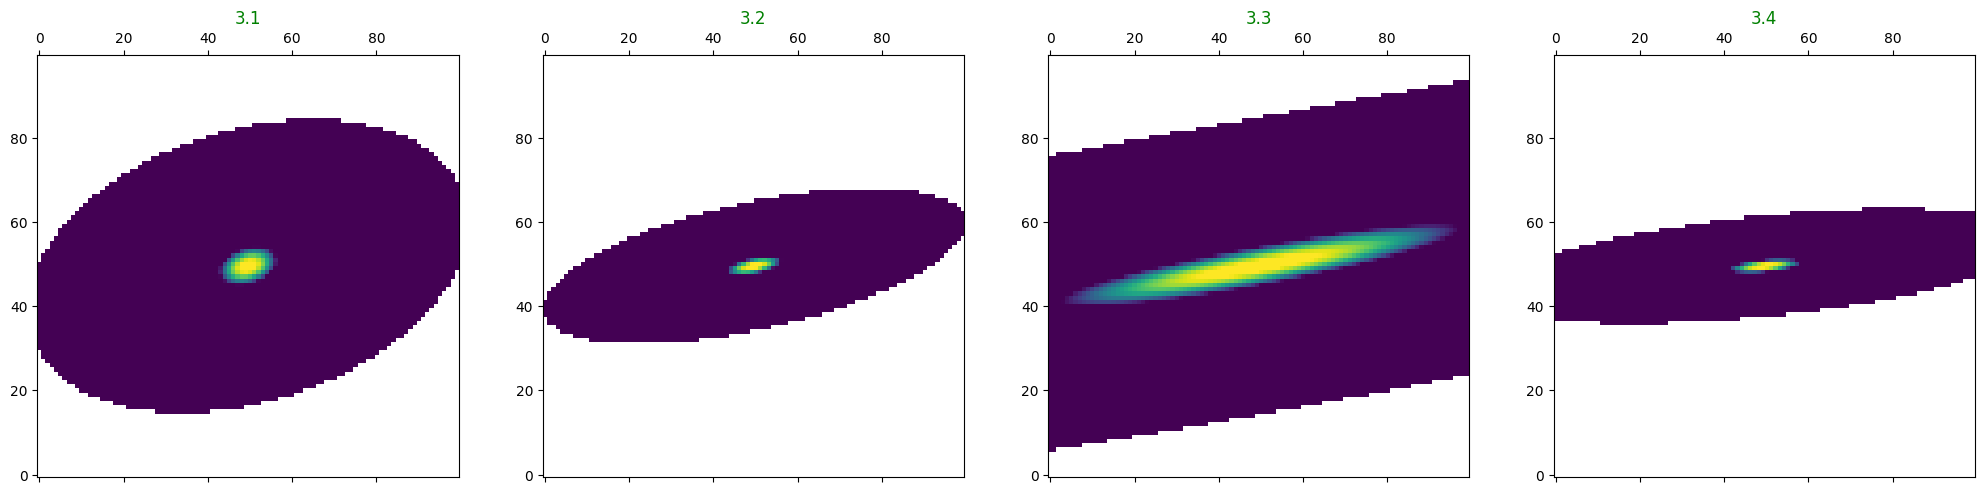

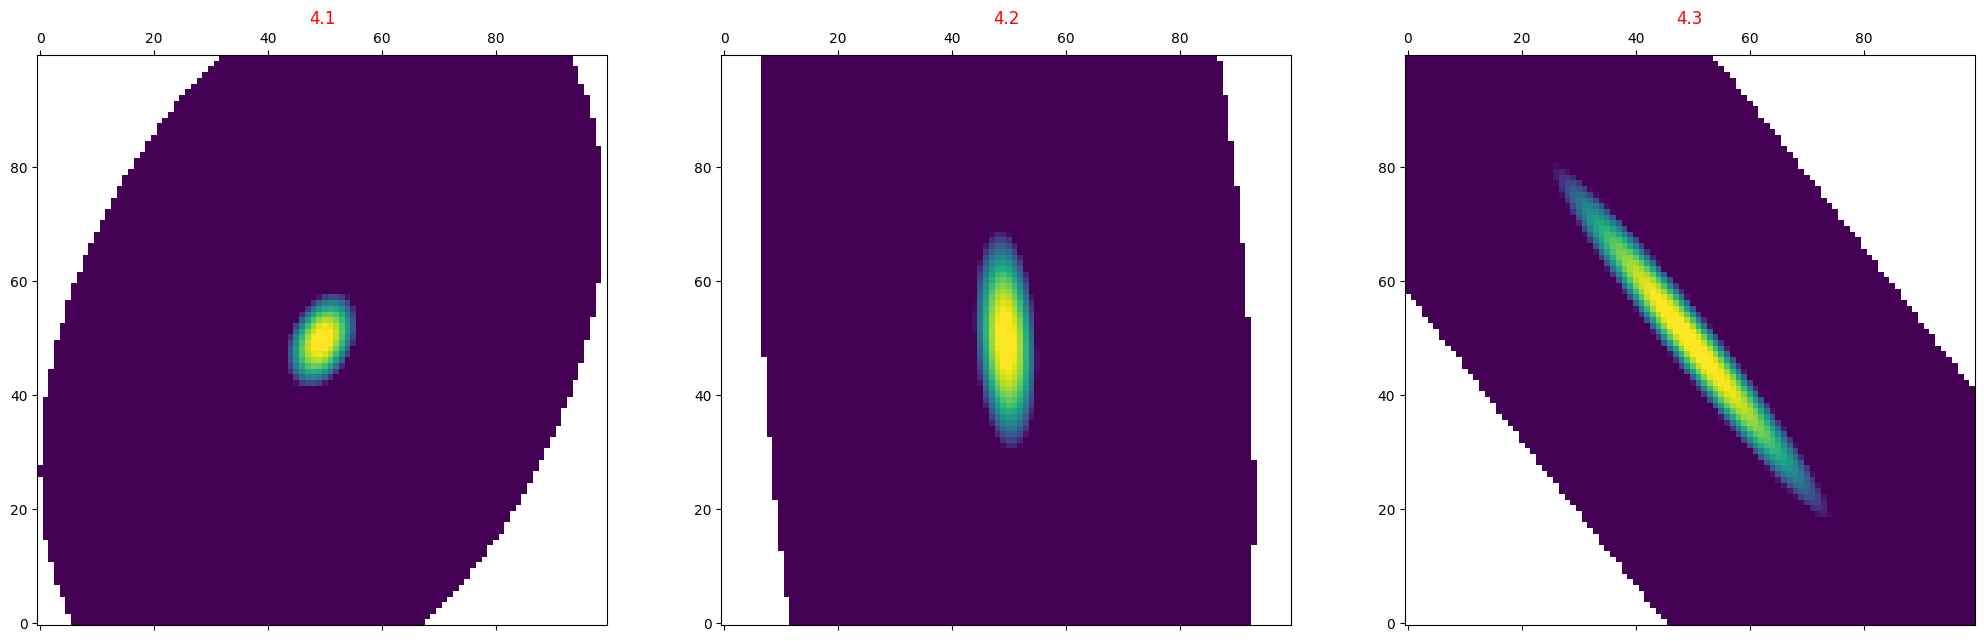

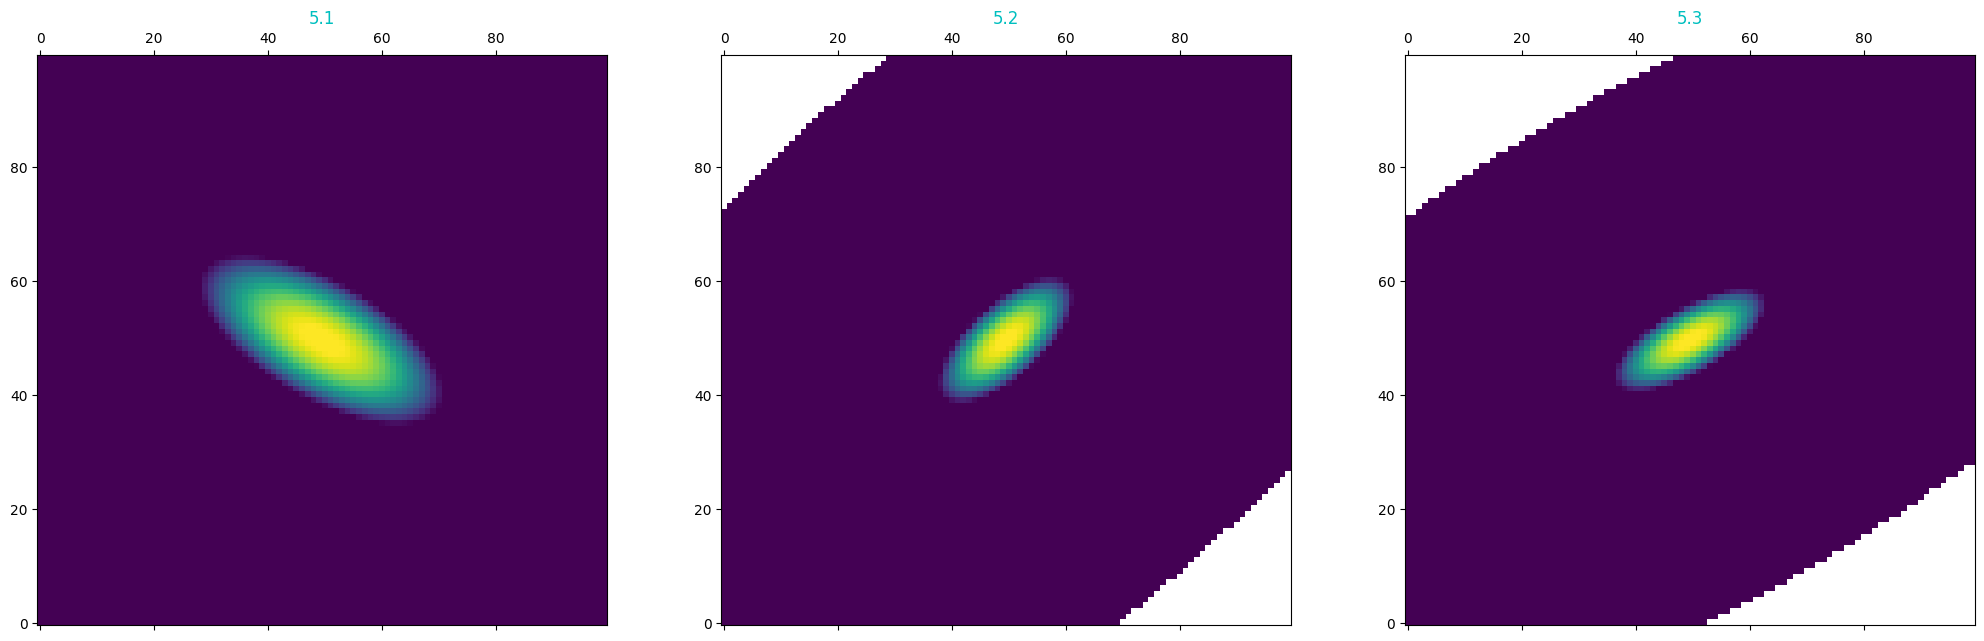

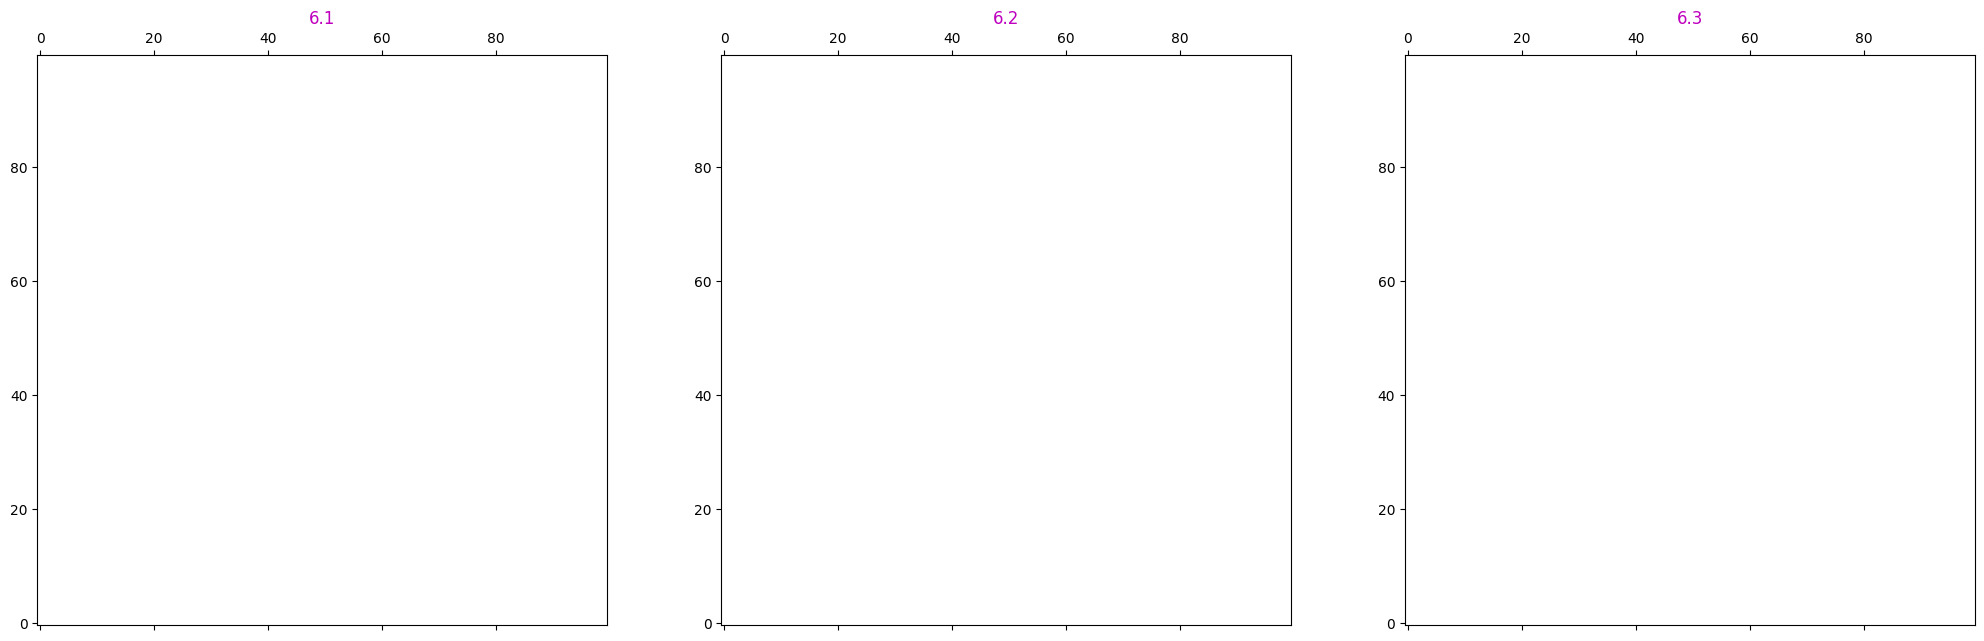

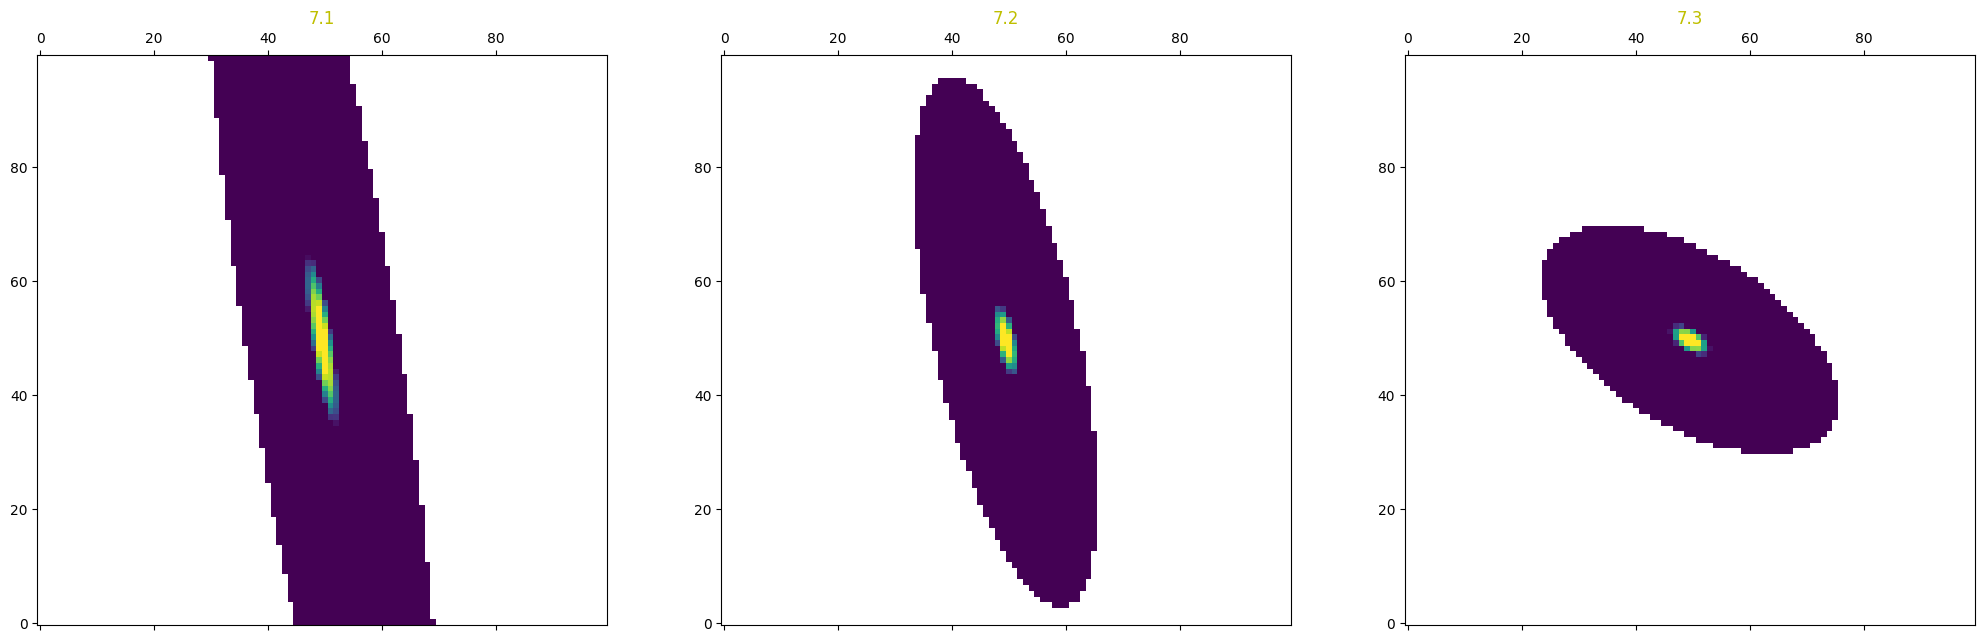

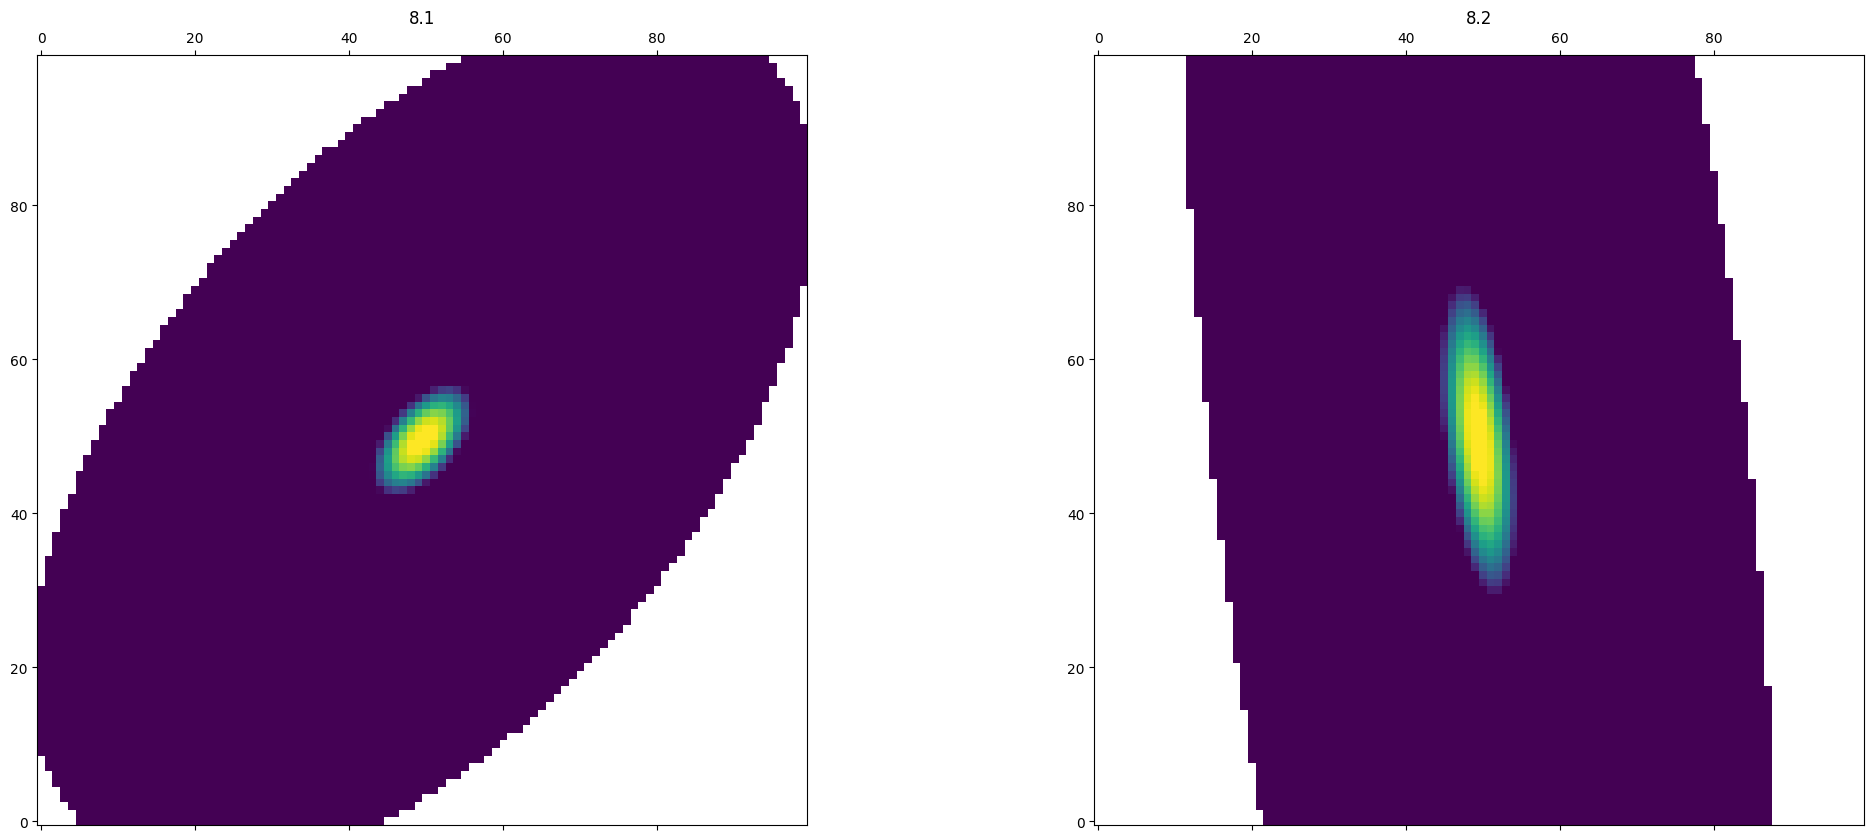

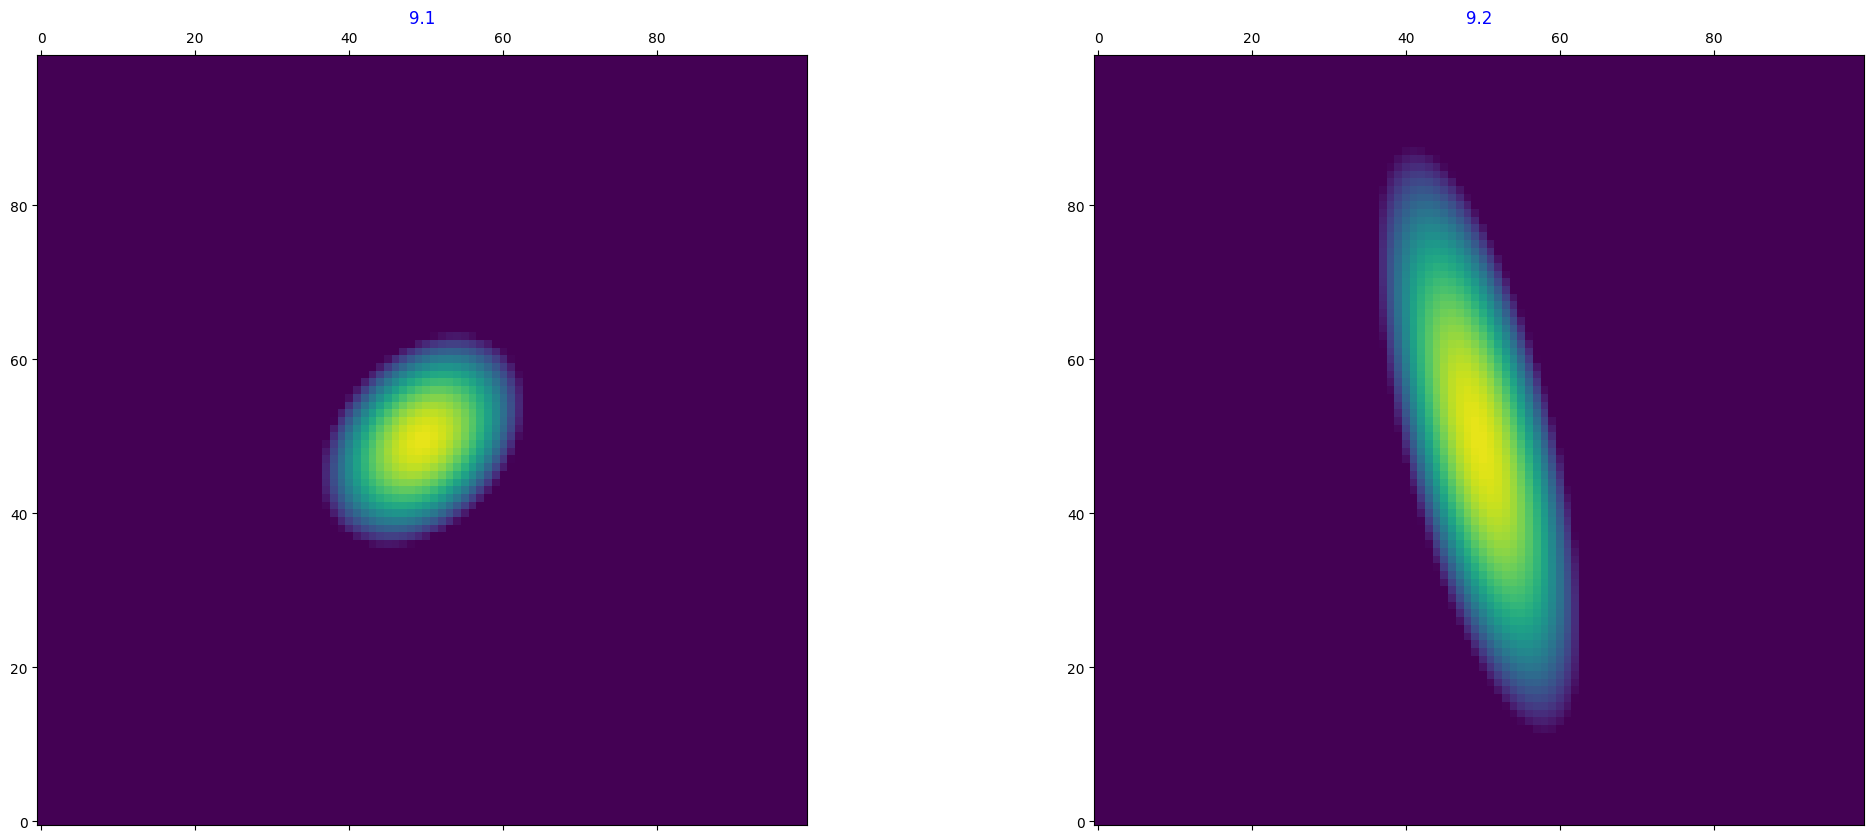

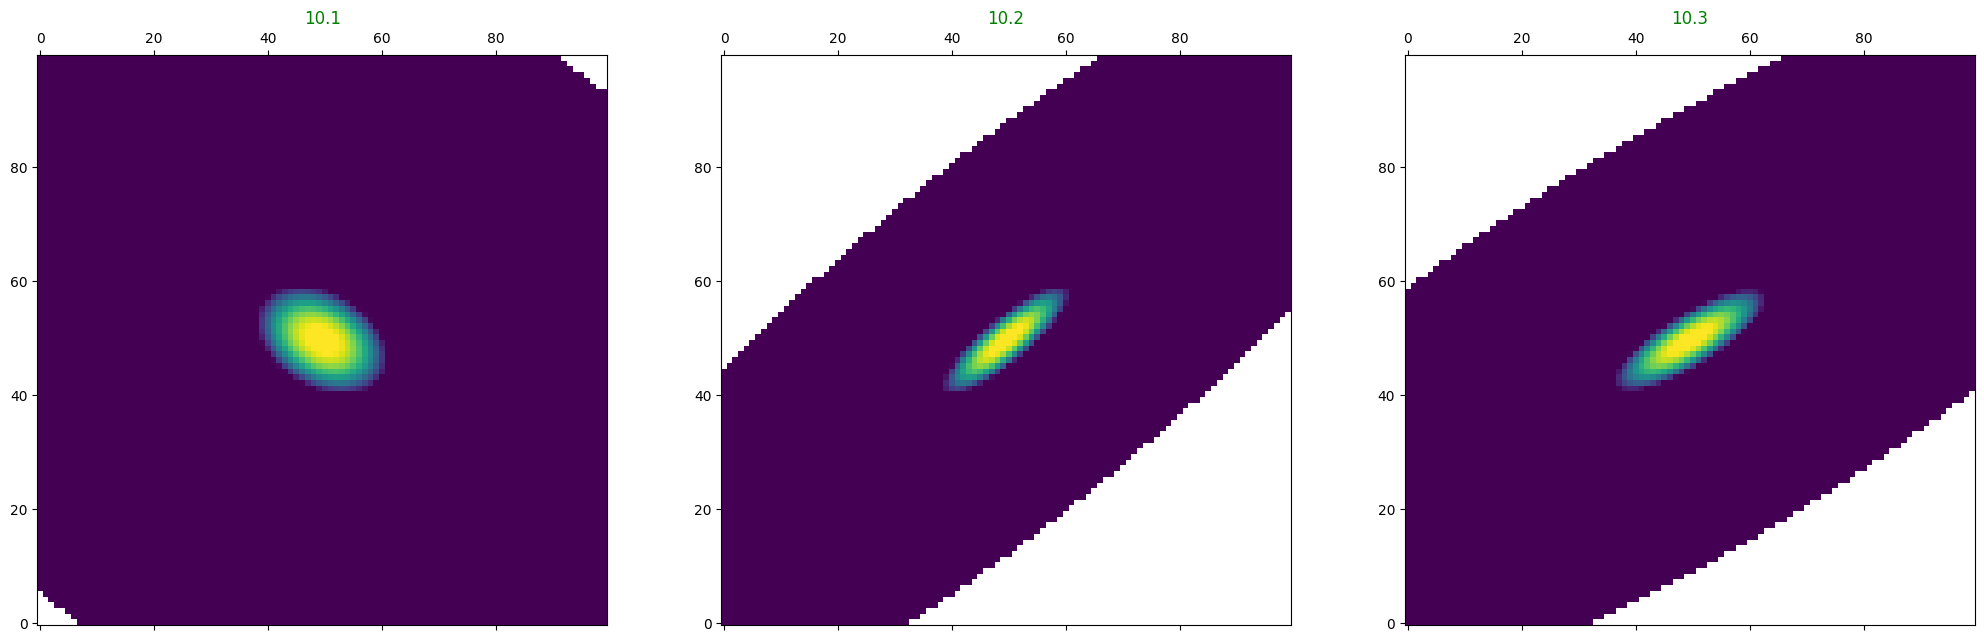

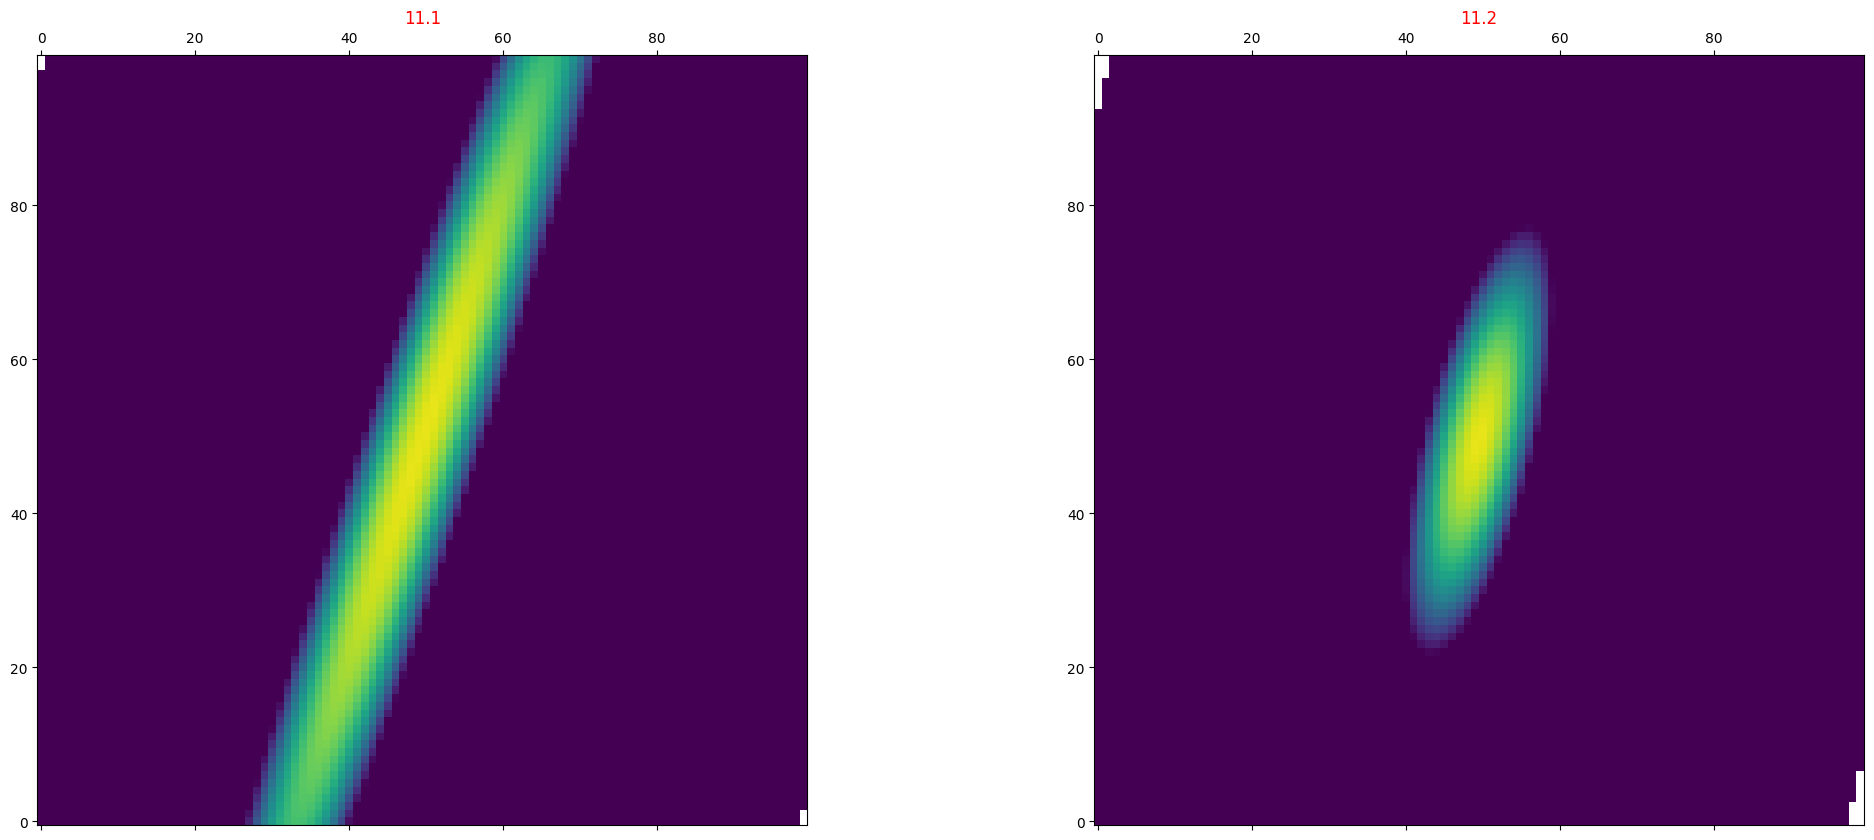

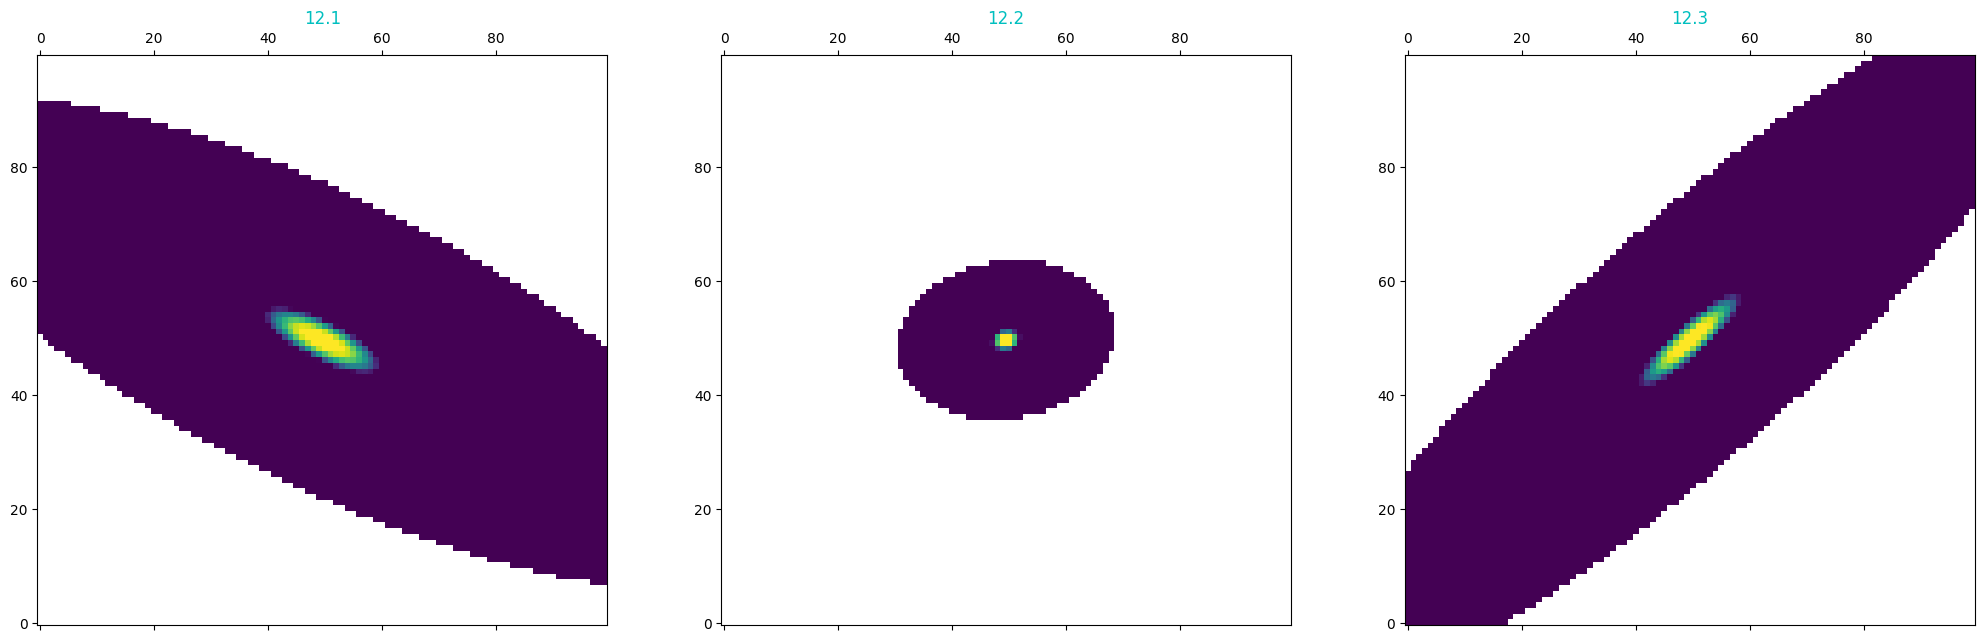

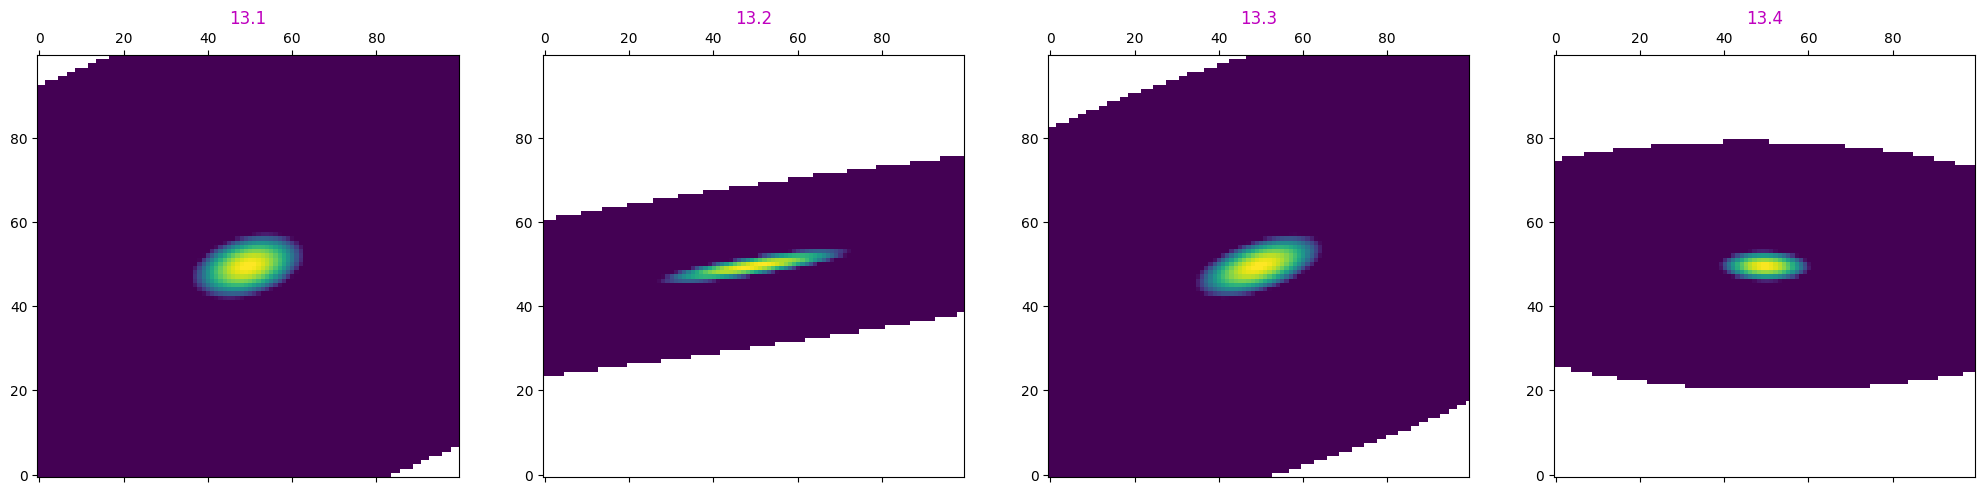

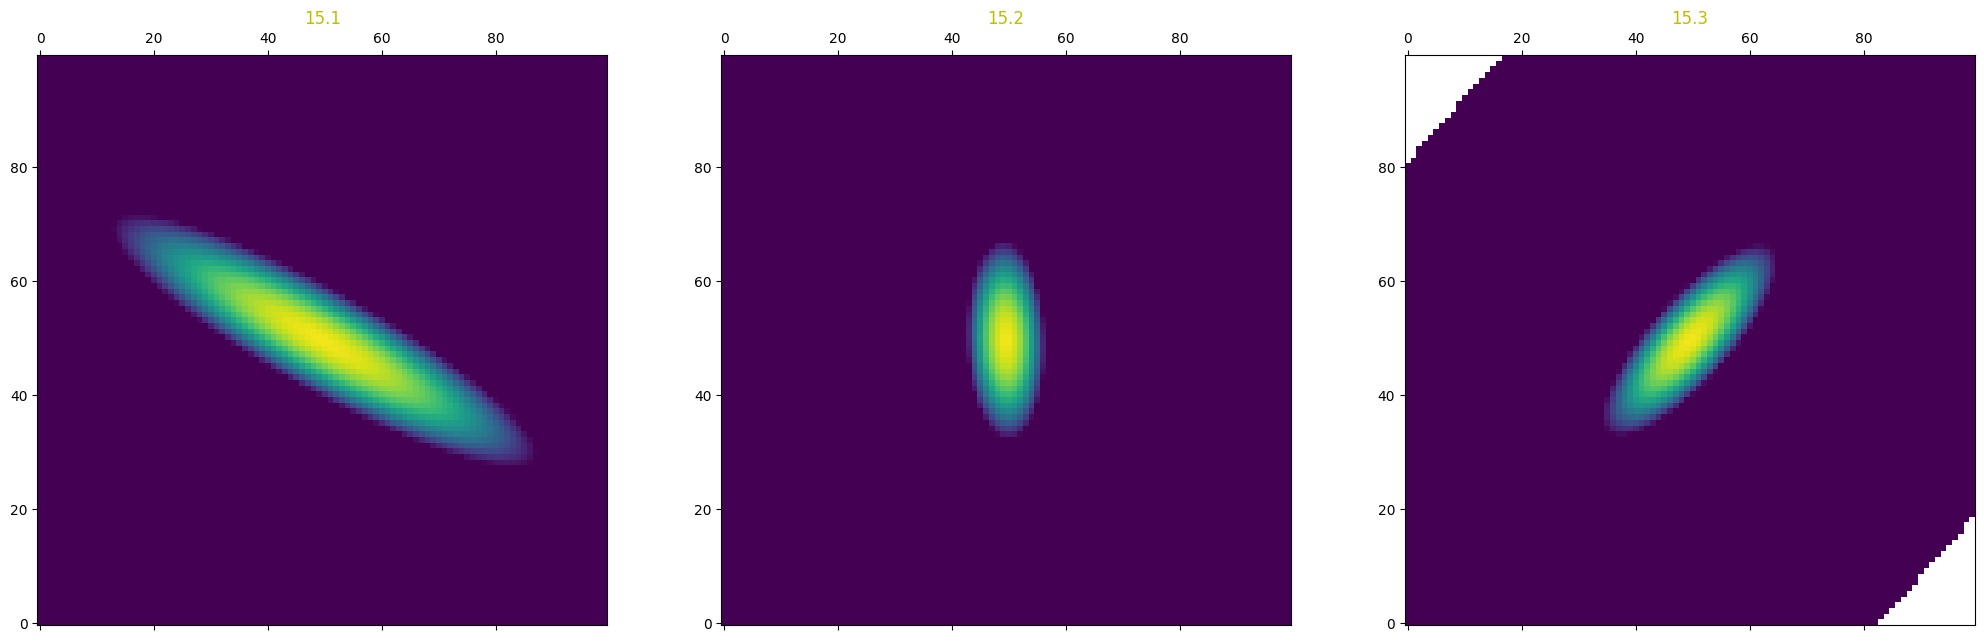

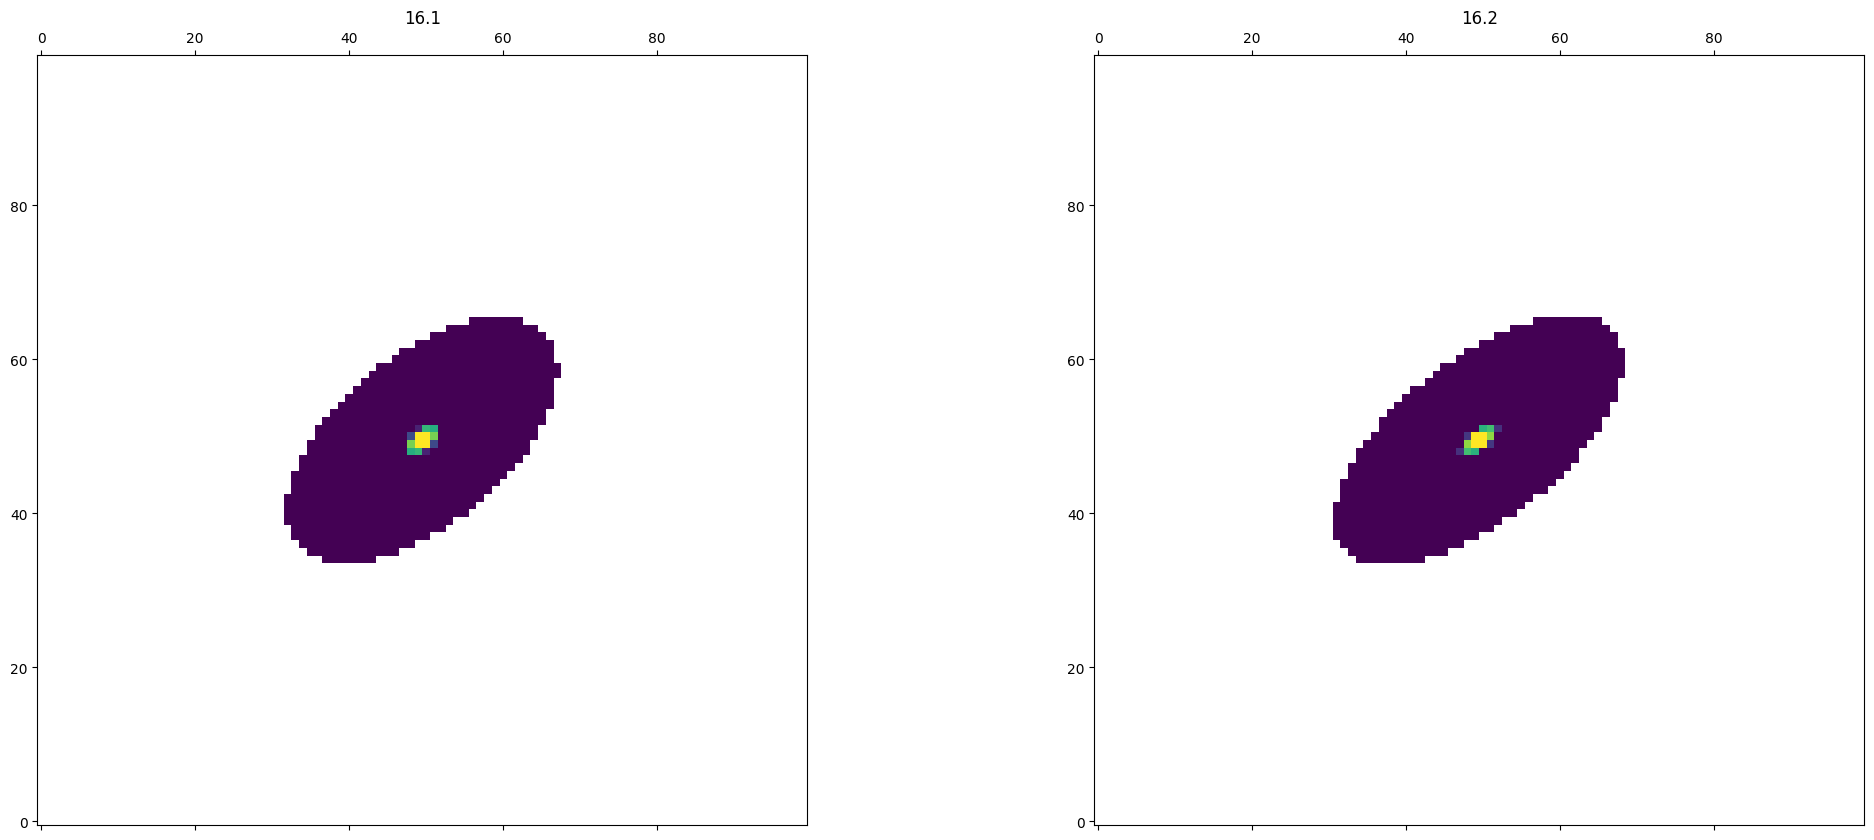

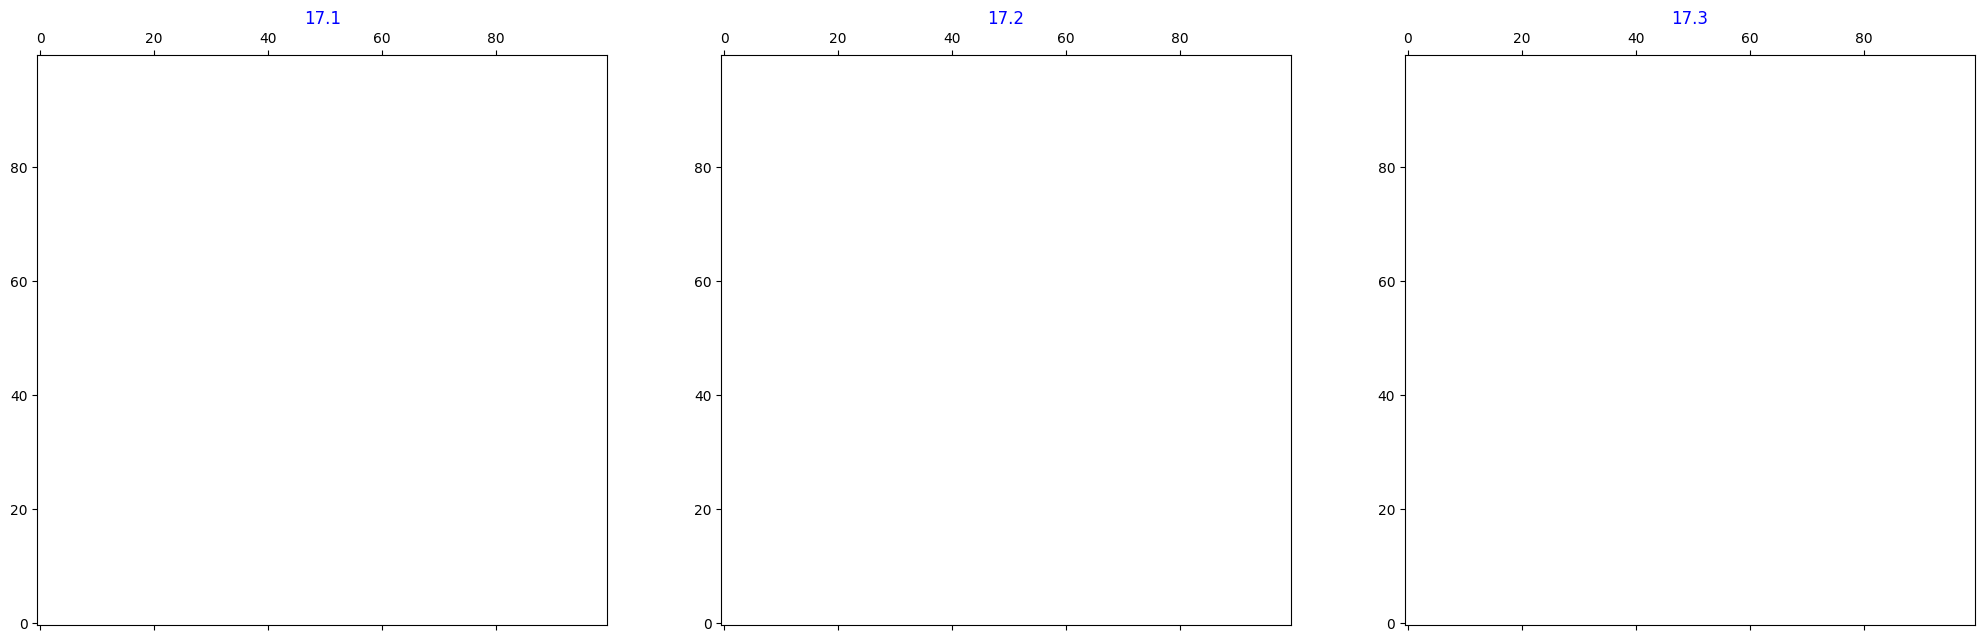

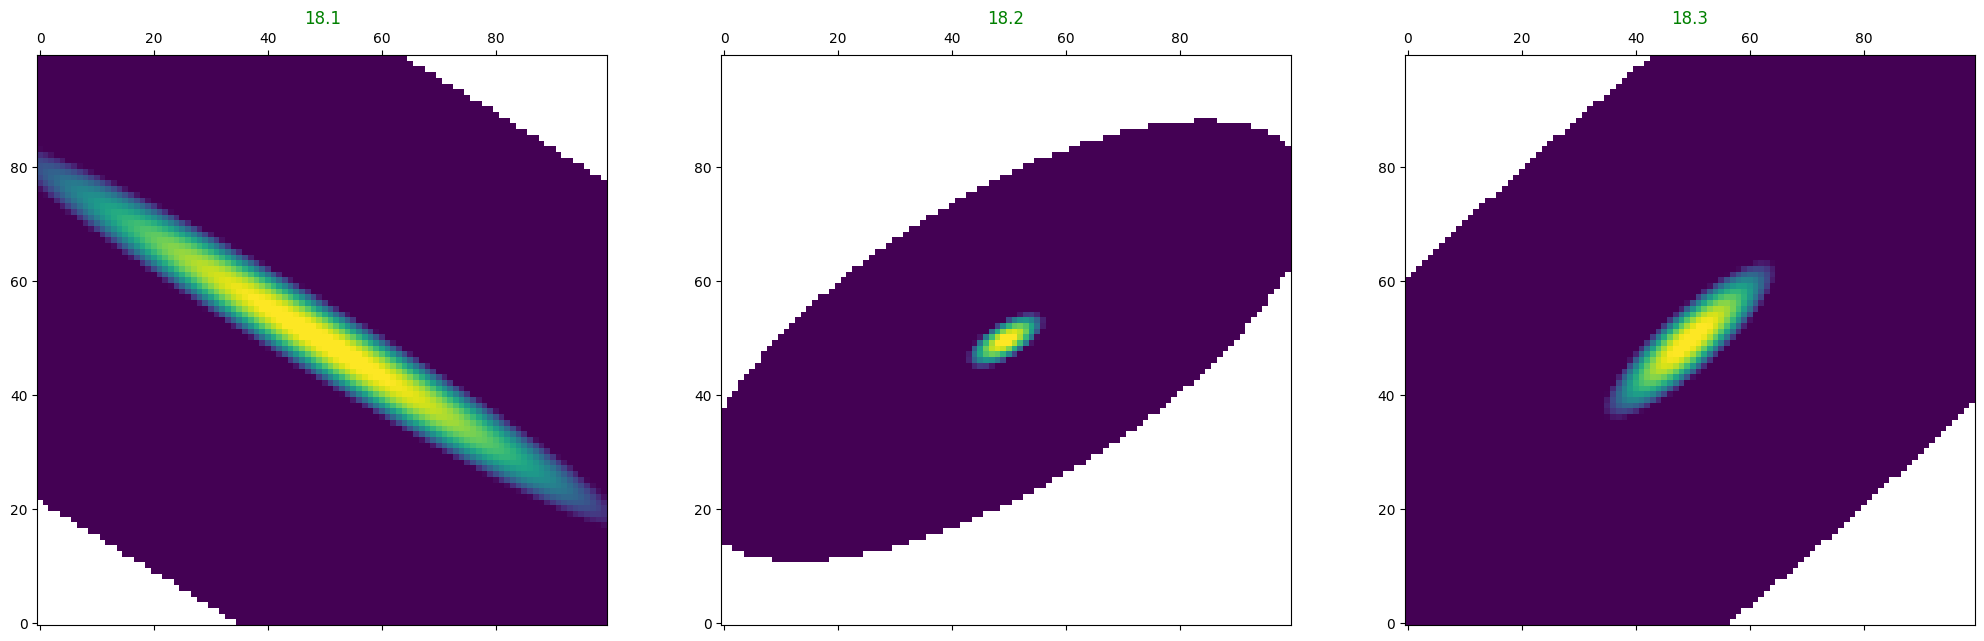

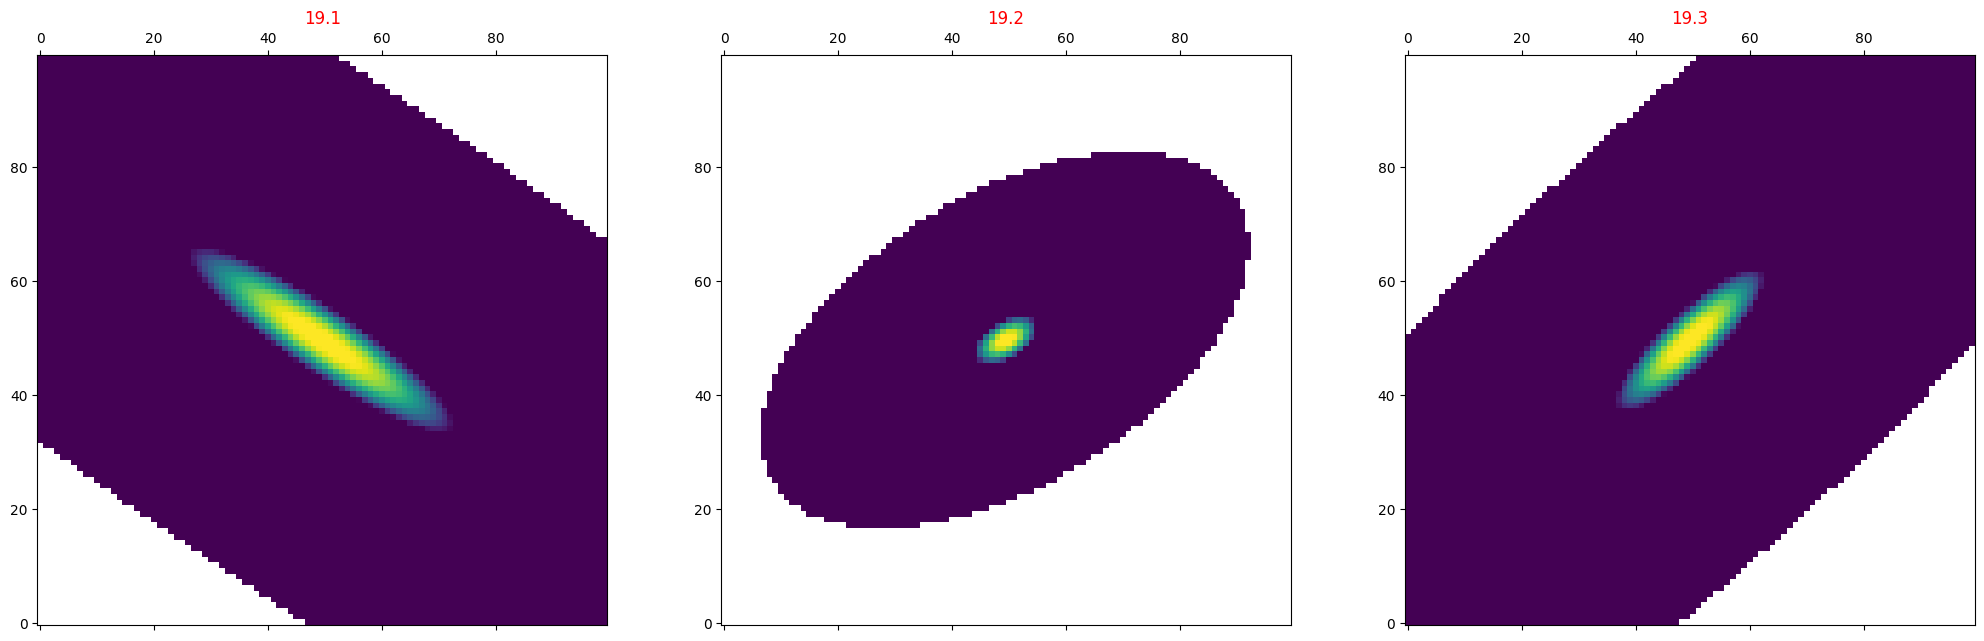

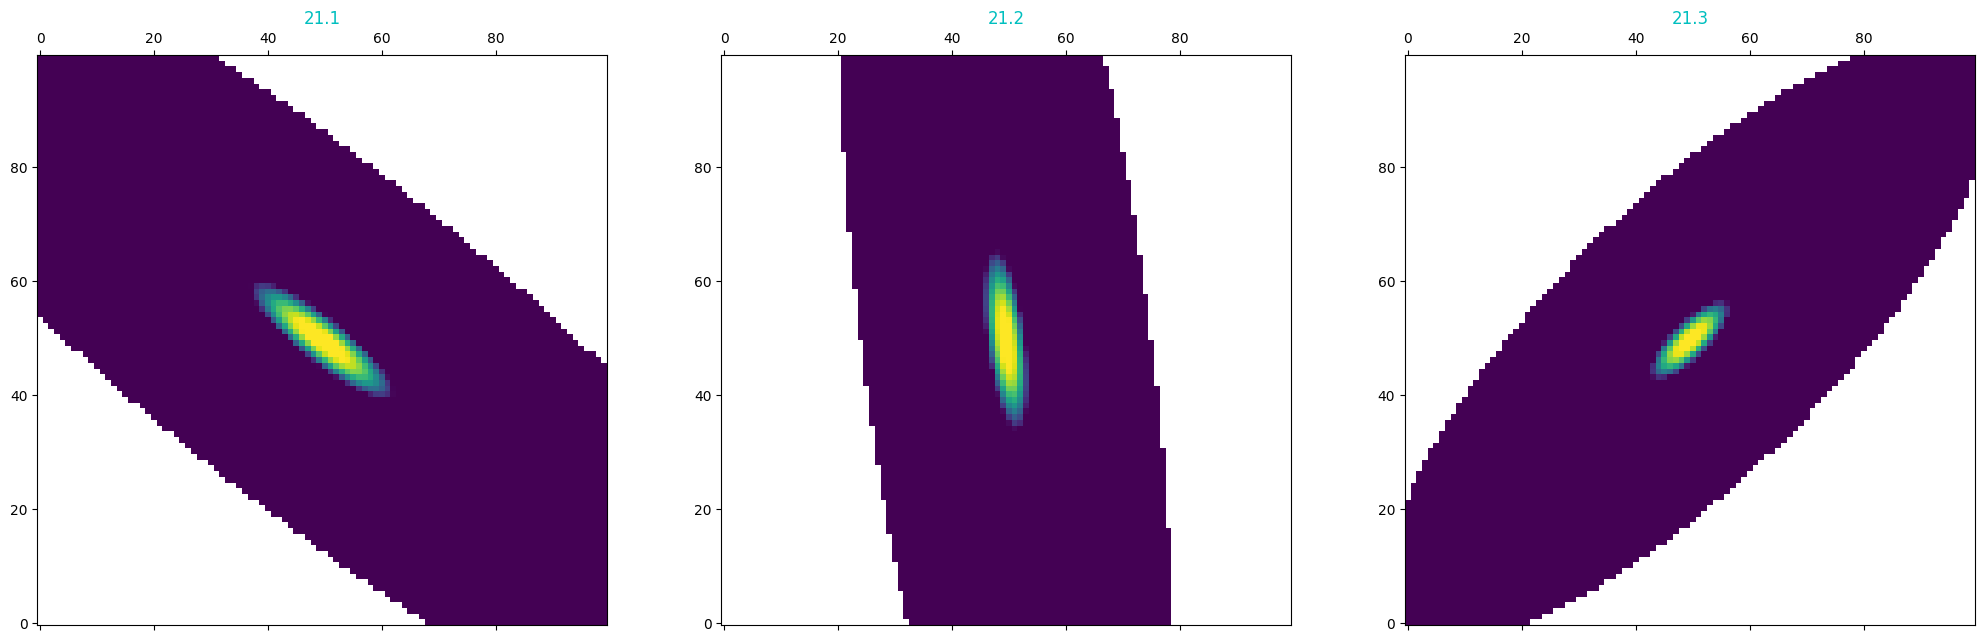

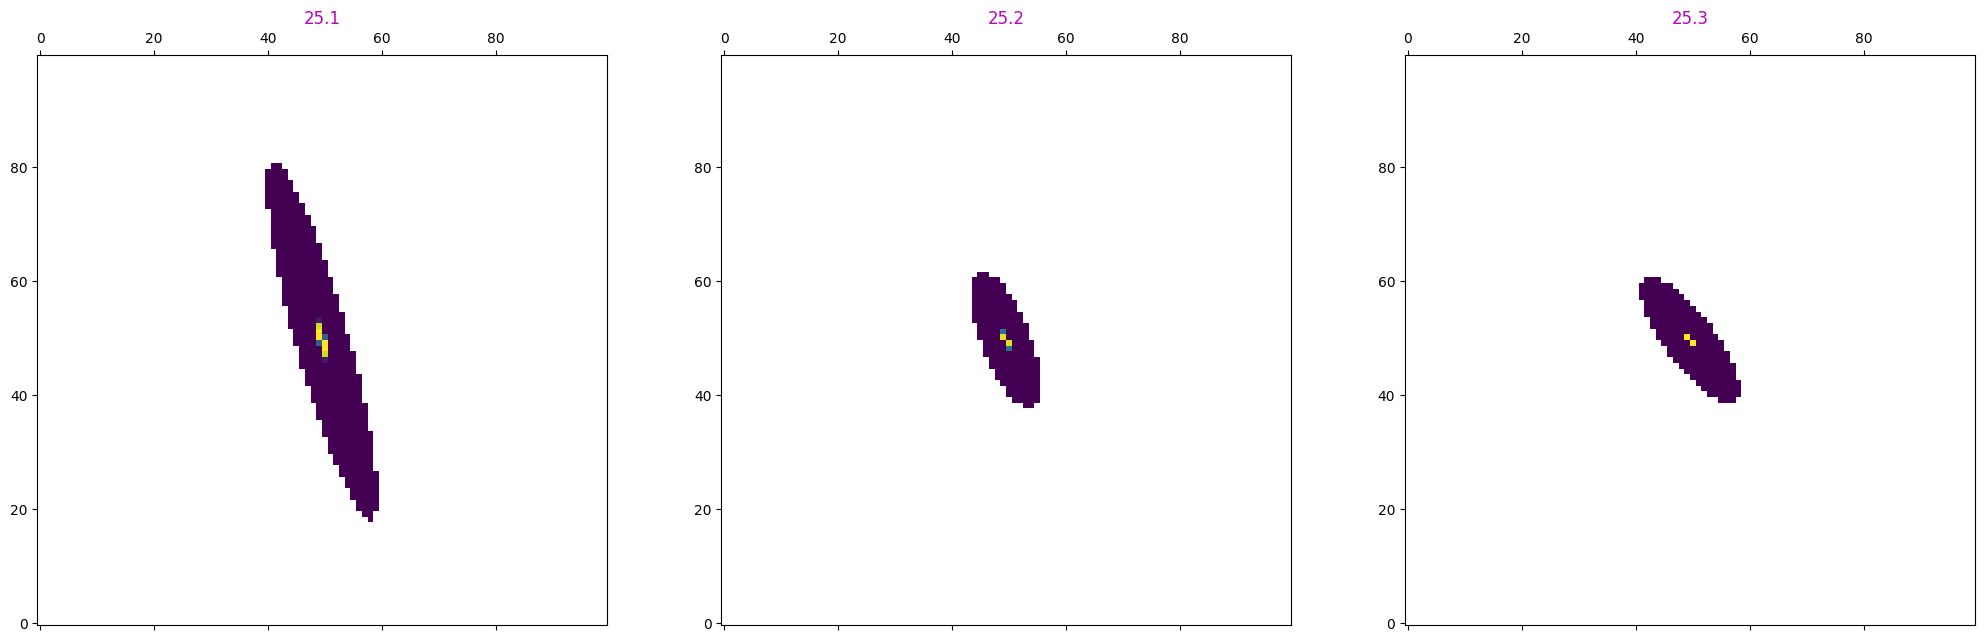

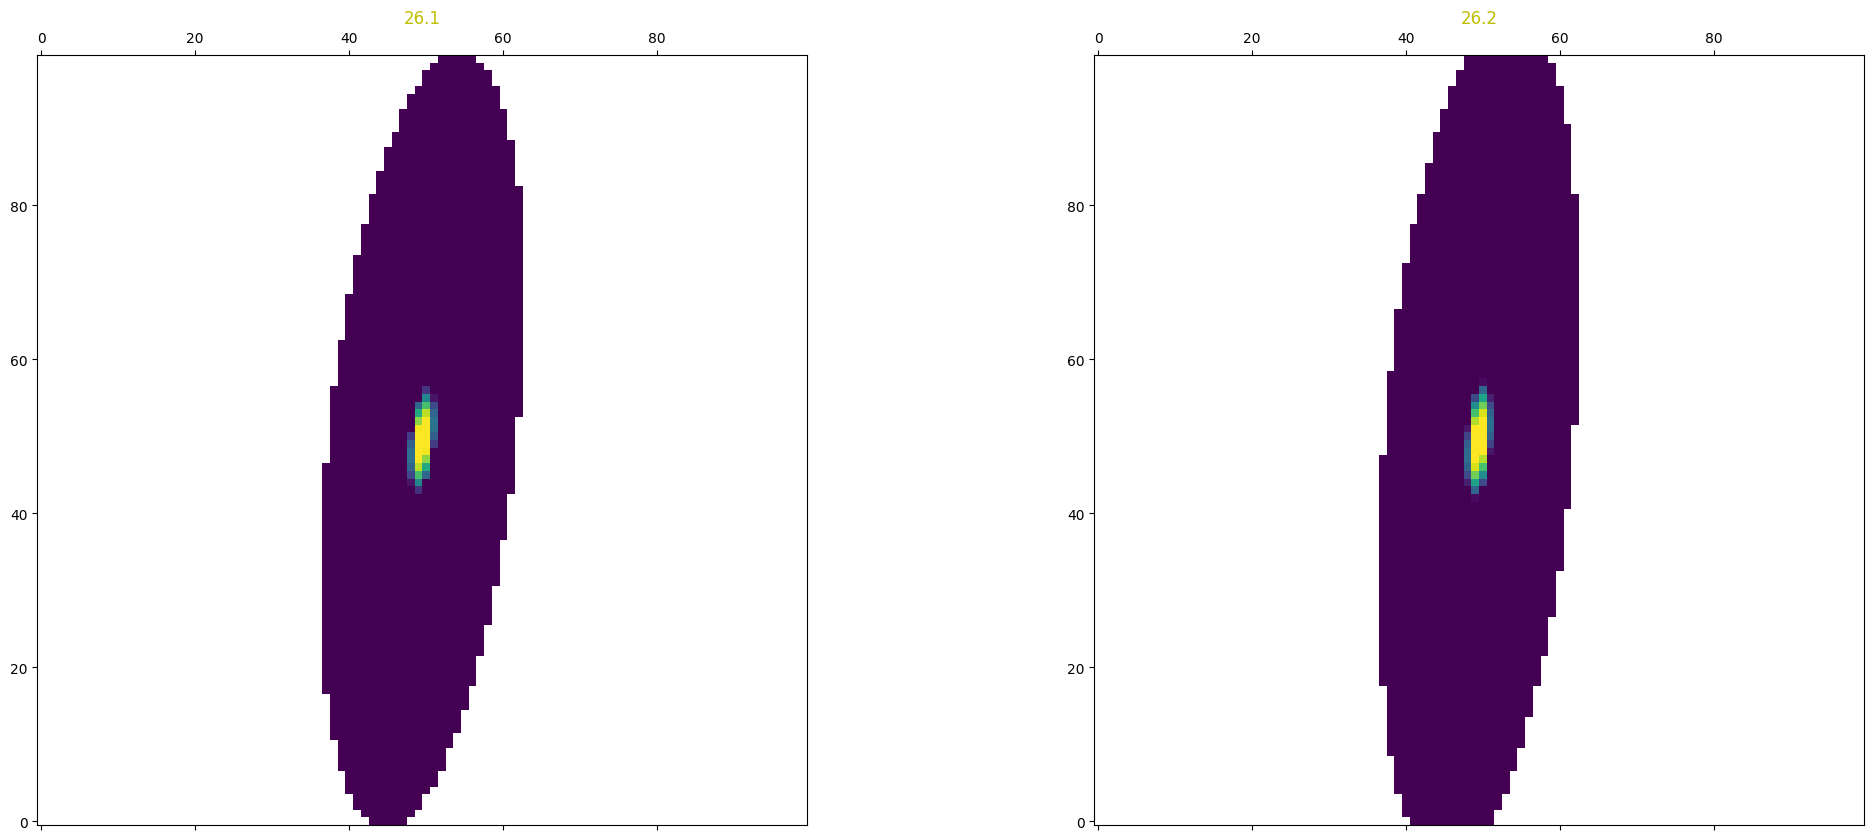

In [45]:
#################### Should work on making this into a function, like the lens_model_plot. Maybe call it something like lensed_multiple_image_plot

# here we plot the finite sources as seen at the different image positions
label_lists = []
for i in range(num_sources_data):
    label_list_temp = [None] * len(grouped_x_pos[i])
    label_lists.append(label_list_temp)

if (Name_list is not None) & (num_Names == 1):
    for i in range(num_sources_data):
        lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources_new[i])
        x_img_indexed = grouped_x_pos[i]
        y_img_indexed = grouped_y_pos[i]
        f, axes = plt.subplots(1, len(x_img_indexed), figsize=(5*5, 5*len(x_img_indexed)), sharex=False, sharey=False)
        for j in range(len(grouped_x_pos[i])):
            label_lists[i][j] = grouped_ids[i][j]
            # str(i+1) + Name_list[0][j]
        for k in range(len(x_img_indexed)):
            lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources_new[i])
            image = lensModelExtensions.zoom_source(x_pos=x_img_indexed[k], y_pos=y_img_indexed[k], kwargs_lens=kwargs_lens, 
                                                            source_sigma=source_sizes_arcsec[i], window_size=window_size,
                                                            grid_number=grid_number)
            ax = axes[k]
            ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
            ax.set_title(label_lists[i][k], color=color_list[i])
        plt.show()
elif (Name_list is not None) & (num_Names > 1):
    for i in range(num_sources_data):
        lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources_new[i])
        x_img_indexed = grouped_x_pos[i]
        y_img_indexed = grouped_y_pos[i]
        f, axes = plt.subplots(1, len(x_img_indexed), figsize=(5*5, 5*len(x_img_indexed)), sharex=False, sharey=False)
        for j in range(len(grouped_x_pos[i])):
            label_lists[i][j] = grouped_ids[i][j]
            # str(i+1) + Name_list[i][j]
        for k in range(len(x_img_indexed)):
            lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources_new[i])
            image = lensModelExtensions.zoom_source(x_pos=x_img_indexed[k], y_pos=y_img_indexed[k], kwargs_lens=kwargs_lens, 
                                                            source_sigma=source_sizes_arcsec[i], window_size=window_size,
                                                            grid_number=grid_number)
            ax = axes[k]
            ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
            ax.set_title(label_lists[i][k], color=color_list[i])
        plt.show()
else:
    for i in range(num_sources_data):
        x_img_indexed = grouped_x_pos[i]
        y_img_indexed = grouped_y_pos[i]
        f, axes = plt.subplots(1, len(x_img_indexed), figsize=(5*5, 5*len(x_img_indexed)), sharex=False, sharey=False)
        label_list = [f"{i+1}A", f"{i+1}B", f"{i+1}C", f"{i+1}D", f"{i+1}E", f"{i+1}F", f"{i+1}G", f"{i+1}H", f"{i+1}I", f"{i+1}J", f"{i+1}K"]
        for j in range(len(x_img_indexed)):
            lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources_new[i])
            image = lensModelExtensions.zoom_source(x_pos=x_img_indexed[i], y_pos=y_img_indexed[i], kwargs_lens=kwargs_lens, 
                                                            source_sigma=source_sizes_arcsec[j], window_size=window_size,
                                                            grid_number=grid_number)
            ax = axes[i]
            ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
            ax.set_title(label_list[i], color=color_list[i])
        plt.show()

## Set up data for modeling
In the previous box, we created a mock lens and computed image positions, flux ratios and time delays.
In this section, we explicitly set up the data products that we want to use for the modeling. You can replace this box with the values for the lens you want to model.

In [46]:
ximgs = []
yimgs = []
flux_ratios_list = []
flux_ratio_errors_list = []
flux_ratios_measured_list = []

for i in range(num_sources_data):
    x_img = x_imgs[i]
    y_img = y_imgs[i]

    image_amps = np.abs(mag_infs[i])
    flux_ratios = image_amps[1:]/image_amps[0]
    flux_ratio_errors = 0.02*np.ones(len(flux_ratios))
    flux_ratios_measured = flux_ratios + np.random.normal(0, flux_ratio_errors)
    if measurement_realization:
        flux_ratios_measured = flux_ratios + np.random.normal(0, flux_ratio_errors)
    else:
        flux_ratios_measured = flux_ratios
    flux_ratios_list.append(flux_ratios)
    flux_ratio_errors_list.append(flux_ratio_errors)
    flux_ratios_measured_list.append(flux_ratios_measured)
print('flux_ratios_list: %s' %(flux_ratios_list))

# the data set is taken from the mock data above (can be replaced by real data)
# image positions in relative RA (arc seconds)

astrometry_sigma = 0.005  # 1-sigma astrometric uncertainties of the image positions (assuming equal precision for all images in RA/DEC directions)

# loop to calculate the time delays
d_dts = []
d_dt_sigmas = []
d_dt_measured_list = []
ximg_measured_list = []
yimg_measured_list = []

for i in range(num_sources_data):
    d_dt = t_days[i][1:] - t_days[i][0]  # lenstronomy definition of relative time delay is in respect of first image in the list (full covariance is in planning)
    d_dt_sigma = 0.5 * np.ones(len(d_dt))
    d_dts.append(d_dt)
    d_dt_sigmas.append(d_dt_sigma)
    
    if measurement_realization:
        d_dt_measured = d_dt + np.random.normal(0, d_dt_sigma)
        ximg_measured = x_imgs[i] + np.random.normal(0, astrometry_sigma, len(x_imgs[i]))
        yimg_measured = y_imgs[i] + np.random.normal(0, astrometry_sigma, len(y_imgs[i]))
    else:
        d_dt_measured = d_dt
        ximg_measured = x_imgs[i]
        yimg_measured = yimgs[i]

    d_dt_measured_list.append(d_dt_measured)
    ximg_measured_list.append(ximg_measured)
    yimg_measured_list.append(yimg_measured)

print(ximg_measured_list)
print(yimg_measured_list)

# here we create a keyword list with all the data elements. If you only have partial information about your lens, only provide the quantities you have.
# kwargs_time_delays_list = []
# kwargs_time_delay_uncertainties_list = []
# kwargs_flux_ratios_list = []
# kwargs_flux_ratio_errors_list = []
kwargs_ra_image_list = []
kwargs_dec_image_list = []


for i in range(num_sources_data):
    # kwargs_time_delays_list.append(d_dt_measured_list[i])
    # kwargs_time_delay_uncertainties_list.append(d_dt_sigmas[i])
    # kwargs_flux_ratios_list.append(flux_ratios_measured_list[i])
    # kwargs_flux_ratio_errors_list.append(flux_ratio_errors_list[i])
    kwargs_ra_image_list.append(ximg_measured_list[i])
    kwargs_dec_image_list.append(yimg_measured_list[i])

kwargs_data_joint = {'ra_image_list': kwargs_ra_image_list, 'dec_image_list': kwargs_dec_image_list}
    #                  'time_delays_measured': kwargs_time_delays_list,
    #                  'time_delays_uncertainties': kwargs_time_delay_uncertainties_list,
    #                  'flux_ratios': kwargs_flux_ratios_list, 
    #                  'flux_ratio_errors': kwargs_flux_ratio_errors_list,
    # don't add this:  'point_source_redshift_list': z_sources_new}

# print("time delay measured", kwargs_data_joint["time_delays_measured"])
# print('ra kwargs: %s \ndec kwargs: %s' %(kwargs_ra_image_list, kwargs_dec_image_list))

flux_ratios_list: [array([1.04976363, 1.08470633]), array([2.27147431, 2.51294142]), array([0.4447661 , 7.34925256, 0.45027632]), array([2.21235396, 3.95217329]), array([0.4195894 , 0.39497651]), array([0.91893086, 0.42900171]), array([0.13964803, 0.08377123]), array([1.89882533]), array([1.81057568]), array([0.37402095, 0.38919707]), array([0.44449091]), array([0.23462847, 0.8532178 ]), array([0.59097308, 0.95444982, 0.54394207]), array([0.30451266, 0.40383726]), array([1.02099302]), array([0.17635007, 0.03808169]), array([0.01716712, 0.05861664]), array([0.08785593, 0.28101508]), array([1.53033719, 0.53457347]), array([0.95689737, 1.1989663 ]), array([1.05320424])]
[array([-18.00412856, -20.92895926, -15.73338527]), array([-15.39320724, -18.08125274, -12.46205496]), array([-4.60816351, -6.5653718 ,  2.03488446,  4.73215987]), array([26.2034576 , 28.51063575, 17.96159422]), array([4.06634953, 6.0820511 , 7.94257649]), array([-11.62162952, -12.81178212,  -4.4673848 ]), array([42.247068

In [47]:
# updated for the new model choice

kwargs_lens_init_ = []
# combine the two here? Or do I have to input the _init_ for each galaxy? and then the dark matter halo?
for i in range(len(gal_data_arcsec)):
    kwargs_lens_init_.append({'sigma0': dPIED_sigma_0s[i], "e1": e1s[i], "e2": e2s[i], 'Ra': float(gal_data_arcsec['a'].iloc[i]), 'Rs': Rt_star_kpc, 'center_x': float(gal_data_arcsec['RA'].iloc[i]), "center_y": float(gal_data_arcsec['DEC'].iloc[i])})
    # kwargs_lens_init_.append({"theta_E": sie_theta_Es[i], "e1": e1s[i], "e2": e2s[i], "center_x": gal_data_arcsec['RA'].iloc[i], "center_y": gal_data_arcsec['DEC'].iloc[i]})
                        #              ^ sie_theta_Es[i] (or 0.2 as a rough estimate)           "gamma": 2
kwargs_lens_init_.append({"Rs": nfw_Rs, "alpha_Rs": nfw_alpha_Rs, "e1": nfw_e1, "e2": nfw_e2, "center_x": float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])})


# old
# kwargs_lens_init_ = ({"sigma0": sigma_0, "Ra": float(input_data_frame['Value'].iloc[66][0]), "Rs": float(input_data_frame['Value'].iloc[67][0]), "e1": 0.5*float(input_data_frame['Value'].iloc[64][0]), "e2": 0.0, "center_x": 0.0, "center_y": 0.0})

print(kwargs_lens_init_)

[{'sigma0': 0.5571152231671601, 'e1': -0.04904835144227604, 'e2': -0.22685761014482453, 'Ra': 0.6012, 'Rs': 20, 'center_x': -11.28084356039193, 'center_y': 87.10452000002533}, {'sigma0': 1.055211944799559, 'e1': 0.0004096789801026205, 'e2': -0.002646365214279174, 'Ra': 0.2628, 'Rs': 20, 'center_x': 44.81321822663787, 'center_y': 25.266959999981964}, {'sigma0': 2.4192601071365796, 'e1': 0.013853329148482103, 'e2': -0.055562668414728456, 'Ra': 0.29, 'Rs': 20, 'center_x': -44.524691857738794, 'center_y': -73.59227999999689}, {'sigma0': 2.911653273119476, 'e1': -0.021693684005130647, 'e2': -0.03526258007598605, 'Ra': 0.255, 'Rs': 20, 'center_x': -0.041686226860088195, 'center_y': 0.04931999998802894}, {'sigma0': 10.868558832982549, 'e1': -0.04280093462643234, 'e2': -0.0008965517729663222, 'Ra': 0.265, 'Rs': 20, 'center_x': 34.281678039568405, 'center_y': 22.06692000000885}, {'sigma0': 2.484318530918001, 'e1': 0.012975965144632111, 'e2': -0.005615201538538019, 'Ra': 0.24, 'Rs': 20, 'center_

## Model settings
Here we set up the modeling (initial guess of the parameters, uncertainties and lower and upper bounds. In this example, we chose the same lens model as we produced the mock data and thus expect a perfect fit.
This part is equal to the imaging simulation of lenstronomy. We refer to other notebooks and the documentation for more details.

In [48]:
# ==================
# lens model choices
# ==================
# this is where things need to be updated to make it fit the new cluster model! Need essentialy a loop to get through each cluster member and then add each one to the kwargs list.
# could also add things that are known very well to the fixed_lens.append({}) list, ie. this could be not empty!

# here we would pick the one we think would fit the image best? Is there some way to know which model we expect to fit best before we run the code?


### for Setting the galaxy lens parameters

# combine the append of all these at the same time as the lens_model_list
# keep the center x, center y, ellipticity fixed
# fix the relative scaling of one deflector and another
# define the scaling ratio with the luminosity with E_radius, fix that, scale up or down all the E_radius simultaneously
    # might be a notebook for this, otherwise, see sampling --> special_param.py
    # mass_scaling (bool) and num_scaling_factor (int) parameters
    # scale factor in
    # should fix theta_E if varying this
#### find the scaling relation between the mass and einstein radius
# in the ellipticity, 

## settings for kwargs_constraints (Param() class)
# mass_scaling = True  # if True, samples scaling parameters
# num_scale_factor = 1  # number of scaling parameters being sampled

mass_scaling_list = []  # False or integer for each mass model, integer, model theta_E gets multiplied with the saling parameter[integer - 1]
for i in range(len(gal_data_arcsec)):
    mass_scaling_list.append(1)
mass_scaling_list.append(False)


################ this for sure needs to be updated! #################


# lens_model_list =  ['PJAFFE_ELLIPSE_POTENTIAL', 'NFW_ELLIPSE_CSE'] #, 'EPL', 'SHEAR', 'SIS', 'SIE']
lens_model_list = []
fixed_lens = []

for i in range(len(gal_data_arcsec)):
    lens_model_list.append('PJAFFE_ELLIPSE_POTENTIAL') #  see short list above
    fixed_lens.append({'sigma0': dPIED_sigma_0s[i], "e1": e1s[i], "e2": e2s[i], 'Ra': float(gal_data_arcsec['a'].iloc[i]), 'Rs': Rt_star_kpc, 'center_x': float(gal_data_arcsec['RA'].iloc[i]), "center_y": float(gal_data_arcsec['DEC'].iloc[i])})
    # fixed_lens.append({"theta_E": sie_theta_E[i], "e1": e1s[i], "e2": e2s[i], "center_x": gal_data_arcsec['RA'].iloc[i], "center_y": gal_data_arcsec['DEC'].iloc[i]})
                    #            ^sie_theta_E[i]      "gamma": 2, 
lens_model_list.append('NFW_ELLIPSE_CSE')
fixed_lens.append({"Rs": nfw_Rs, "alpha_Rs": nfw_alpha_Rs, "e1": nfw_e1, "e2": nfw_e2, "center_x": float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])})
# fixed_lens.append({"Rs": float(input_data_frame['Value'].iloc[66][0]), "alpha_Rs": 0.5, "e1": float(input_data_frame['Value'].iloc[64][0]), "e2": 0.0, "center_x": float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])})

kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# SPEMD parameters
# for i in range(len(lens_model_list)):
#     fixed_lens.append({})

################## Need to update this to fit the model choices for the SIE and NFW lens models!
######### look at the data to see the limits for each of the parameters. Need an instance of the values for each model. Add them to the corresponding list, not just init!!

# append once for each of the cluster members, then once for the dark matter halo

### update to dPIED and NFW_CSE profiles                    # SIE and NFW profiles

#kwargs_lens_init.append(kwargs_lens[0])
for i in range(len(gal_data_arcsec)):
    # initial parameter guess
    kwargs_lens_init.append(kwargs_lens[i])     # {"theta_E": 0.2, "e1": e1s[i], "e2": e2s[i], "center_x": gal_data_arcsec['RA'].iloc[i], "center_y": gal_data_arcsec['DEC'].iloc[i]})
    # initial particle cloud
    kwargs_lens_sigma.append({'sigma0': 0.01, 'e1': 0.01, 'e2': 0.01, 'Ra': 1.0, 'Rs': 17, 'center_x': 0.1, 'center_y': 0.1})
    # {'sigma0': dPIED_sigma_0s[i], "e1": e1s[i], "e2": e2s[i], 'Ra': float(gal_data_arcsec['a'].iloc[i]), 'Rs': Rt_star, 'center_x': float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])}
        # {"theta_E": 0.01, "e1": 0.01, "e2": 0.01, "center_x": 0.1, "center_y": 0.1})
    # hard lower bound limit of parameters
    kwargs_lower_lens.append({'sigma0': 0, 'e1': -0.5, 'e2': -0.5, 'Ra': 0, 'Rs': 0, 'center_x': -100, 'center_y': -100})
        # {"theta_E": 0, "e1": -0.5, "e2": -0.5, "center_x": -100, "center_y": -100})
    # hard upper bound limit of parameters
    kwargs_upper_lens.append({'sigma0': 10, 'e1': 0.5, 'e2': 0.5, 'Ra': 100, 'Rs': 100, 'center_x': 100, 'center_y': 100})
        # {"theta_E": 1.0, "e1": 0.5, "e2": 0.5, "center_x": 100, "center_y": 100})
    
    # old
    # kwargs_lens_init.append({"sigma0": 1.5, "Ra": 1.0, "Rs": 17, "e1": 0.1, "e2": 0.01, "center_x": 0.1, "center_y": -0.1})
    # kwargs_lens_sigma.append({"sigma0": 0.01, "Ra": 0.1, "Rs": 0.1, "e1": 0.01, "e2": 0.01, "center_x": 0.1, "center_y": 0.1})
    # kwargs_lower_lens.append({"sigma0": 0, "Ra": 0, "Rs": 0, "e1": -0.5, "e2": -0.5, "center_x": -100, "center_y": -100})
    # kwargs_upper_lens.append({"sigma0": 10, "Ra": 100, "Rs": 100, "e1": 0.5, "e2": 0.5, "center_x": 100, "center_y": 100})

# same kwargs but for the nfw dark matter halo
kwargs_lens_init.append(kwargs_lens[-1])        # {"Rs": nfw_Rs, "alpha_Rs": nfw_alpha_Rs, "e1": nfw_e1, "e2": nfw_e2, "center_x": float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])})
kwargs_lens_sigma.append({"Rs": 0.1, "alpha_Rs": 0.1, "e1": 0.01, "e2": 0.01, "center_x": 0.1 , "center_y": 0.01})
kwargs_lower_lens.append({"Rs": 0, "alpha_Rs": 0, "e1": -0.5, "e2": -0.5, "center_x": -100, "center_y": -100})
kwargs_upper_lens.append({"Rs": 100, "alpha_Rs": 10, "e1": 0.5, "e2": 0.5, "center_x": 100, "center_y": 100})

#old:
# kwargs_lens_init.append({"Rs": float(input_data_frame['Value'].iloc[66][0]), "alpha_Rs": 1, "e1": 0.5*float(input_data_frame['Value'].iloc[64][0]), "e2": 0.0, "center_x": float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])}) 
# kwargs_lens_sigma.append({"Rs": 0.1, "alpha_Rs": 0.1, "e1": 0.01, "e2": 0.01, "center_x": 0.1, "center_y": 0.1}) 
# kwargs_lower_lens.append({"Rs": 0, "alpha_Rs": 0, "e1": -0.5, "e2": -0.5, "center_x": -100, "center_y": -100}) 
# kwargs_upper_lens.append({"Rs": 100, "alpha_Rs": 10, "e1": 0.5, "e2": 0.5, "center_x": 100, "center_y": 100}) 



# # append the values for the dPIED model
# kwargs_lens_init_list.append(kwargs_lens_init[0])
# kwargs_lens_sigma_list.append(kwargs_lens_sigma[0])
# kwargs_lower_lens_list.append(kwargs_lower_lens[0])
# kwargs_upper_lens_list.append(kwargs_upper_lens[0])

# # append the values for the NFW model
# kwargs_lens_init_list.append(kwargs_lens_init[1])
# kwargs_lens_sigma_list.append(kwargs_lens_sigma[1])
# kwargs_lower_lens_list.append(kwargs_lower_lens[1])
# kwargs_upper_lens_list.append(kwargs_upper_lens[1])

# SHEAR parameters
# we keep the center of shear definition fixed at (0,0). Want to make sure that things aren't moving, they're just being sheared?
# for i in range(len(lens_model_list)):
# fixed_lens.append({'ra_0': 0, 'dec_0': 0})
# kwargs_lens_init.append({'gamma1': 0.0, 'gamma2': 0.0})
# kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
# kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})
# kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})

# combine all parameter options for lenstronomy
lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]
print('kwargs_lens_init len: %s, data: %s' %(len(kwargs_lens_init), kwargs_lens_init))
print('fixed_lens len: %s, data: %s' %(len(fixed_lens), fixed_lens))
print('kwargs_lens_sigma_list len: %s, data: %s' %(len(kwargs_lens_sigma), kwargs_lens_sigma))
print('kwargs_lower_lens_list len: %s, data: %s' %(len(kwargs_lower_lens), kwargs_lower_lens))
print('kwargs_upper_lens_list len: %s, data: %s' %(len(kwargs_upper_lens), kwargs_upper_lens))

kwargs_lens_init len: 149, data: [{'sigma0': 0.5571152231671601, 'e1': -0.04904835144227604, 'e2': -0.22685761014482453, 'Ra': 0.6012, 'Rs': 20, 'center_x': -11.28084356039193, 'center_y': 87.10452000002533}, {'sigma0': 1.055211944799559, 'e1': 0.0004096789801026205, 'e2': -0.002646365214279174, 'Ra': 0.2628, 'Rs': 20, 'center_x': 44.81321822663787, 'center_y': 25.266959999981964}, {'sigma0': 2.4192601071365796, 'e1': 0.013853329148482103, 'e2': -0.055562668414728456, 'Ra': 0.29, 'Rs': 20, 'center_x': -44.524691857738794, 'center_y': -73.59227999999689}, {'sigma0': 2.911653273119476, 'e1': -0.021693684005130647, 'e2': -0.03526258007598605, 'Ra': 0.255, 'Rs': 20, 'center_x': -0.041686226860088195, 'center_y': 0.04931999998802894}, {'sigma0': 10.868558832982549, 'e1': -0.04280093462643234, 'e2': -0.0008965517729663222, 'Ra': 0.265, 'Rs': 20, 'center_x': 34.281678039568405, 'center_y': 22.06692000000885}, {'sigma0': 2.484318530918001, 'e1': 0.012975965144632111, 'e2': -0.00561520153853801

In [54]:
# =========================
# image position parameters
# =========================

# we chose to model the image positions in the lensed plane (we know where they appear) and fix the image position coordinates
point_source_list = []
fixed_ps = []
kwargs_ps_init = []
kwargs_ps_sigma = []
kwargs_lower_ps = []
kwargs_upper_ps = []

for i in range(num_sources_data):
    point_source_list.append('LENSED_POSITION')
    fixed_ps.append({})  # we fix the image position coordinates
    kwargs_ps_init.append({'ra_image': ximg_measured_list[i], 'dec_image': yimg_measured_list[i]})
    kwargs_ps_sigma.append({'ra_image': 0.01 * np.ones(len(x_imgs[i])), 'dec_image': 0.01 * np.ones(len(y_imgs[i]))})
    kwargs_lower_ps.append({'ra_image': -10 * np.ones(len(x_imgs[i])), 'dec_image': -10 * np.ones(len(y_imgs[i]))})
    kwargs_upper_ps.append({'ra_image': 10* np.ones(len(x_imgs[i])), 'dec_image': 10 * np.ones(len(y_imgs[i]))})

# combine all parameter options for lenstronomy
ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

fixed_special = {}
# below were originally dictionaries, made into lists to fix error 'can't iterate over an int'. Changed to 'list indices must be integers or slices, not str' when calculating the log likelihood
# kwargs_special_init = []
# kwargs_special_sigma = []
# kwargs_lower_special = []
# kwargs_upper_special = []
kwargs_special_init = {}
kwargs_special_sigma = {}
kwargs_lower_special = {}
kwargs_upper_special = {}

# =========================
# astrometric perturbations
# =========================
# astrometric perturbations are modeled in lenstronomy with 'delta_x_image' and 'delta_y_image'.
# These perturbations place the 'actual' point source at the difference to 'ra_image'.
# we let some freedom in how well the actual image positions are matching those given by the data (indicated as 'ra_image', 'dec_image' and held fixed while fitting)

#kwargs_special_init['delta_x_image'], kwargs_special_init['delta_y_image'] = np.zeros_like(ximg), np.zeros_like(yimg)
#kwargs_special_sigma['delta_x_image'], kwargs_special_sigma['delta_y_image'] = np.ones_like(ximg) * astrometry_sigma, np.ones_like(yimg) * astrometry_sigma
#kwargs_lower_special['delta_x_image'], kwargs_lower_special['delta_y_image'] = np.ones_like(ximg) * (-1), np.ones_like(yimg) * (-1)
#kwargs_upper_special['delta_x_image'], kwargs_upper_special['delta_y_image'] = np.ones_like(ximg) * (1), np.ones_like(yimg) * (1)

# ==================
# quasar source size
# ==================
# # If you want to keep the source size fixed during the fitting, don't comment the line below (or comment the line to let it vary).
# fixed_special['source_size'] = [source_size_arcsec, source_size_arcsec2]
# kwargs_special_init['source_size'] = [source_size_arcsec, source_size_arcsec2]
# kwargs_special_sigma['source_size'] = [source_size_arcsec, source_size_arcsec2]
# or:
# kwargs_special_init['source_size'] = source_sizes_arcsec[0]
# kwargs_special_sigma['source_size'] = source_sizes_arcsec[0]
# fixed_special['source_size'] = source_sizes_arcsec[0]

# kwargs_lower_special['source_size'] = 0.0001
# kwargs_upper_special['source_size'] = 1


# ===================
# Time-delay distance
# ===================
# with time-delay information, we can measure the time-delay distance (units physical Mpc)

# if you want to fix the cosmology and instead use the time-delay information to constrain the lens model, out-comment the line below
    # essentially, choose either the first line of the above block of code, or the first line of the below block of code
#fixed_special['D_dt'] = lensCosmo.D_dt
# kwargs_special_init['D_dt'] = lensCosmo.ddt
# kwargs_special_sigma['D_dt'] = 2000
# kwargs_lower_special['D_dt'] = 0
# kwargs_upper_special['D_dt'] = 10000

# mass scaling parameter configuraiton
# for i in range(num_sources_data):
#     kwargs_special_init.append({'scale_factor': 1})
#     kwargs_special_sigma.append({'scale_factor': 0.2})
#     kwargs_lower_special.append({'scale_factor': 0})
#     kwargs_upper_special.append({'scale_factor': 10})
kwargs_special_init['scale_factor'] = [1]
kwargs_special_sigma['scale_factor'] = [0.2]
kwargs_lower_special['scale_factor'] = [0]
kwargs_upper_special['scale_factor'] = [10]

special_params = [kwargs_special_init, kwargs_special_sigma, fixed_special, kwargs_lower_special, kwargs_upper_special]
print("special_params:", special_params)

# combined parameter settings
kwargs_params = {'lens_model': lens_params,
                'point_source_model': ps_params,
                'special': special_params}

# our model choices
kwargs_model = {'lens_model_list': lens_model_list, 
                'point_source_model_list': point_source_list,
                'point_source_redshift_list': z_sources_new,           # add this for changing redshifts of sources!
                'z_source_convention': z_source_convention,
                'z_lens': z_lens,
                'cosmo': cosmo}

print("point_source_list:", point_source_list)
print("fixed_lens:", fixed_lens)
print("fixed_ps:", fixed_ps)
print("fixed_special:", fixed_special)
print("kwargs_special_init:", kwargs_special_init)

special_params: [{'scale_factor': [1]}, {'scale_factor': [0.2]}, {}, {'scale_factor': [0]}, {'scale_factor': [10]}]
point_source_list: ['LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION']
fixed_lens: [{'sigma0': 0.5571152231671601, 'e1': -0.04904835144227604, 'e2': -0.22685761014482453, 'Ra': 0.6012, 'Rs': 20, 'center_x': -11.28084356039193, 'center_y': 87.10452000002533}, {'sigma0': 1.055211944799559, 'e1': 0.0004096789801026205, 'e2': -0.002646365214279174, 'Ra': 0.2628, 'Rs': 20, 'center_x': 44.81321822663787, 'center_y': 25.266959999981964}, {'sigma0': 2.4192601071365796, 'e1': 0.013853329148482103, 'e2': -0.055562668414728456, 'Ra': 0.29, '

## setup options for likelihood and parameter sampling
In $\texttt{lenstronomy}$ the likelihood settings (which likelihood gets evaluated) and the parameter sampling options (which parameters get sampled) are separated. It is upon the user to decide the appropriate parameters to be sampled for the given choice of likelihood and information.

In [55]:
# so I'd have to turn these on or off depending on what model/information I have
time_delay_likelihood = False  # bool, set this True or False depending on whether time-delay information is available and you want to make use of its information content.
flux_ratio_likelihood = False  # bool, modeling the flux ratios of the images
image_position_likelihood = True  # bool, evaluating the image position likelihood (in combination with astrometric errors)

kwargs_flux_compute = {'source_type': 'INF',  # you can either chose 'INF' which is a infinetesimal source size, 'GAUSSIAN' or 'TORUS'
                       'window_size': window_size, # window size to compute the finite source magnification (only when 'GAUSSIAN' or 'TORUS' are chosen.)
                       'grid_number': grid_number}  # number of grid points (per axis) to compute the extended source surface brightness within the window_size around the image position
num_images_list = []
for i in range(num_sources_data):
    num_images = len(x_imgs[i])
    num_images_list.append(num_images)
# print(num_images_list)

kwargs_constraints = {'num_point_source_list': num_images_list, 'Ddt_sampling': time_delay_likelihood,
                      "mass_scaling_list": mass_scaling_list,
                      } # sampling of the time-delay distance

# ATTENTION: make sure that the numerical options are chosen to provide accurate computations for the finite source magnifications!
# what are the numerical vs not-numerical options? Just the gaussian and torus options?
if kwargs_flux_compute['source_type'] in ['GAUSSIAN', 'TORUS'] and flux_ratio_likelihood is True:
    kwargs_constraints['source_size'] = True  # explicit sampling of finite source size parameter (only use when source_type='GAUSSIAN' or 'TORUS')

# we can define un-correlated Gaussian priors on specific parameters explicitly
# e.g. power-law mass slope of the main deflector
prior_lens = [[0, 'center_x', 0, 0.01], [0, 'center_y', 0, 0.01]] # [[0, 'gamma', 2, 0.1],[index_model, 'param_name', mean, 1-sigma error], [...], ...]
# e.g. source size of the emission region
prior_lens_light = []
prior_special = []
    
kwargs_likelihood = {  
                     'image_position_uncertainty': astrometry_sigma,  # astrometric uncertainty of image positions
                     'image_position_likelihood': True,               # evaluate point source likelihood given the measured image positions
                     'time_delay_likelihood': False,  # evaluating the time-delay likelihood
                     'flux_ratio_likelihood': False,  # enables the flux ratio likelihood 
                     'kwargs_flux_compute': kwargs_flux_compute,      # source_type='INF' will lead to point source
                     'prior_lens': prior_lens,
                     'prior_lens_light': prior_lens_light,
                     'prior_special': prior_special,
                     'check_bounds': True,                            # check parameter bounds and punish them
                    }


## Multiple image position constraints
Matching multiple image position constraints from the same source is a difficult and computationally tedious task. Here we discuss a few different approaches, their pros and cons and how they are implemented in lenstronomy.

1. Sampling the source position and solving the lens equation: The conceptually most straight forward approach is to sample the source position and the lens model and then compute the image positions by solving the lens equation. Apart from having the model priors well under control, this method comes with some draw-backs: (1) Solving the lens equation is computationally expensive. (2) small changes in the source position lead to significant changes in the predicted image positions in highly magnified regions and the sampling becomes inefficient. (3) the number of images appearing is not preserved and different predicted positions can not unambiguosly be matched to data points.
Lenstronomy can deal with the sampling of the source position but the image positions can not be dealt with in catalogue form but only in terms of a simulated image. This method is not recommended.

IS 2 THE ONE WE WANT?

2. Sampling the image position and ray-tracing to the source position: Computationally much easier and with parameters reflecting the data much closer is chosing the image position as the sampling parameters and ray-trace back to the source plane to compute the source position. The problem: In general, the different images do not match precisely back to the same source position and the lens equation can be severely invalidated. Satisfying the lens equation is key in accurately predicting the relative time delays. Errors introduced when not matching the lens equation are discussed e.g. in Birrer & Treu 2019.
The work-around in lenstronomy: You can introduce a punishing term in the likelihood to downweight proposed models that do not meet a certain requirement in how accurately the lens equation is satisfied. In the limit of having infinite requirements on the lens equation, sampling becomes untractable. Even when the desire is having very high accuracy, sampling will lead to a non-linear degeneracy as effectively the number of sampled parameters (2x number of image positions - 2 source positions) is under-constraint. The numerical precision has to be carefully chosen to gage accuracy vs. sampling efficiency. Also: the numerical precision imposed is effectively a prior in the sampling! The numerical precision must be chosen magnification-independent to not propagate to a prior in e.g. the power-law slope inference. Lenstronomy deals with it by imposing the required source position accuracy as magnified in the image plane to avoid biases.

3. Non-linear solving of lens model parameters to satisfy the lens equation: A way to circumvene the issue of the under-constraint sampling in (2) still taking the benefit of not solving the lens equation is to constrain part of the lens model through applying a non-linear solver on the ray-tracing to match the source position. This is faster than solving the lens equation and provides an efficient sampling as the parameters are the image positions. A possible draw-back is the behaviour of the solver and the prior on these constraint model parameters are not well phrased. The advantage is that all proposed models are a solution to the lens equation to high numerical precision.

4. Fixing image position and translating astrometric uncertainties to the source plane: This is a fast and efficient method to allow for constraints on lens model parameters from multiply observed images. However the lens models that are being sampled do not satisfy the lens equation. When computing the time delays, the image positions have to be computed for the proposed lens model by solving the lens equation and at these positions the Fermat potential/time delay needs to be evaluated.

In [59]:
# setting the non-linear solver accoring to option (3)
kwargs_constraints['solver_type'] = 'NONE'  # 'PROFILE_SHEAR', 'NONE', # any proposed lens model must satisfy the image positions appearing at the position of the point sources being sampeled

# checking for matched source position in ray-tracing the image position back to the source plane.
# This flag should be set =True when dealing with option (2) and (3)
# kwargs_likelihood['check_matched_source_position'] = True  # check non-linear solver and discard non-solutions # removed by simon in a recent PR
kwargs_likelihood['source_position_tolerance'] = 2  # hard bound tolerance on r.m.s. scatter in the source plane to be met in the sampling

# desired precision on r.m.s. scatter in the source plane to achive. 
# This is implemented as a Gaussian likelihood term and is met when the model is sufficient in describing the data
# This precision must be set when using option (2). Option (3) should guarantee a very high precision except in some failures of the solver.
kwargs_likelihood['source_position_sigma'] = 0.005

# setting to propagate the astrometric uncertainties in image position into a likelihood in the source position.
# Option (4) above. This option can be used SEPARATE to the solver or the source position tolerance (see below)
# Care has to be taken when requiring time-delay predictions.
kwargs_likelihood['source_position_likelihood'] = True  # evaluates how close the different image positions match the source positons]
kwargs_likelihood['image_position_uncertainty'] = astrometry_sigma  # this option (4) uses the 'image_position_uncertainty' to translate to a source position uncertainty (see also Birrer & Treu 2019)

In [60]:
print('ps_init: %s, lens: %s, special_init: %s' %(len(kwargs_ps_init), len(kwargs_lens), len(kwargs_special_init)))

ps_init: 21, lens: 149, special_init: 1


## log_likelihood test

In [61]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

kwargs_truth = {"kwargs_ps": kwargs_ps_init, "kwargs_lens": kwargs_lens, "kwargs_source": {}, "kwargs_special": kwargs_special_init,
                "kwargs_lens_light": None, "kwargs_tracer_source": None}
log_likelihood = fitting_seq.likelihoodModule.log_likelihood(kwargs_truth, verbose=True)

print(log_likelihood)

Prior likelihood = -38572274.179344244
Image positions of image 0 of model 0 do not match to the same source position to the required precision. Achieved: [1.03293793 2.41819741], Required: 2.
Image positions of image 1 of model 0 do not match to the same source position to the required precision. Achieved: [-2.05162415  2.06881264], Required: 2.
Image positions of image 2 of model 0 do not match to the same source position to the required precision. Achieved: [ 1.01868621 -4.48701004], Required: 2.
Image positions of image 0 of model 1 do not match to the same source position to the required precision. Achieved: [0.71274877 3.41205336], Required: 2.
Image positions of image 1 of model 1 do not match to the same source position to the required precision. Achieved: [-2.29827755  2.32903607], Required: 2.
Image positions of image 2 of model 1 do not match to the same source position to the required precision. Achieved: [ 1.58552878 -5.74108944], Required: 2.
Image positions of image 0 of

## Run the modeling - Particle Swarm Optimization to find a maxima in the likelihood

In [60]:
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 400, 'n_iterations': 800}]] #['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}]]
# you can add additional fixed parameters in the line above if you want
# SB had n_iterations as 400, but 500 seems to be fine too, just runs longer.

start_time = time.time()
chain_list_pso = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
Converged after 187 iterations!
Best fit found:  -1000000000000000000 [np.float64(1.5), np.float64(1.0), np.float64(17.0), np.float64(0.1), np.float64(0.01), np.float64(0.1), np.float64(-0.1), np.float64(0.739248), np.float64(1.0), np.float64(0.0805), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-18.0116482894522), np.float64(-20.916591484499566), np.float64(-15.729305704770704), np.float64(13.121257537753042), np.float64(-0.4184784286299642), np.float64(-14.622823340290338), np.float64(-15.381335678996324), np.float64(-18.069355738343624), np.float64(-12.463886399622364), np.float64(13.209559804876479), np.float64(-1.7584837309431882), np.float64(-14.723997351403476), np.float64(-4.601402495727037), np.float64(-6.568108023886014), np.float64(2.026933745554018), np.float64(4.7184667006598495), np.float64(21.93064430102388), np.float64(-1.7203262930381324), np.float64(-18.18973910008550

In [62]:
fitting_seq.best_fit_likelihood(verbose=True)

parameter 13 with value -18.0116482894522 hit the bounds [-10.0, 10.0] 


-1000000000000000000

parameter 13 with value -18.0116482894522 hit the bounds [-10.0, 10.0] 
kwargs_results {'kwargs_lens': [{'sigma0': 1.5, 'Ra': 1.0, 'Rs': 17, 'e1': 0.1, 'e2': 0.01, 'center_x': 0.1, 'center_y': -0.1}, {'Rs': 0.739248, 'alpha_Rs': 1, 'e1': 0.0805, 'e2': 0.0, 'center_x': 0.0, 'center_y': 0.0}], 'kwargs_source': [], 'kwargs_lens_light': [], 'kwargs_ps': [{'ra_image': array([-18.01164829, -20.91659148, -15.7293057 ]), 'dec_image': array([ 13.12125754,  -0.41847843, -14.62282334])}, {'ra_image': array([-15.38133568, -18.06935574, -12.4638864 ]), 'dec_image': array([ 13.2095598 ,  -1.75848373, -14.72399735])}, {'ra_image': array([-4.6014025 , -6.56810802,  2.02693375,  4.7184667 ]), 'dec_image': array([ 21.9306443 ,  -1.72032629, -18.1897391 ,  -0.3988405 ])}, {'ra_image': array([26.20678469, 28.51946442, 17.96365746]), 'dec_image': array([-13.34379911,   0.31902883,  21.37014135])}, {'ra_image': array([4.05227021, 6.07801723, 7.95473476]), 'dec_image': array([ 10.22194019,   6.98782877, -19.

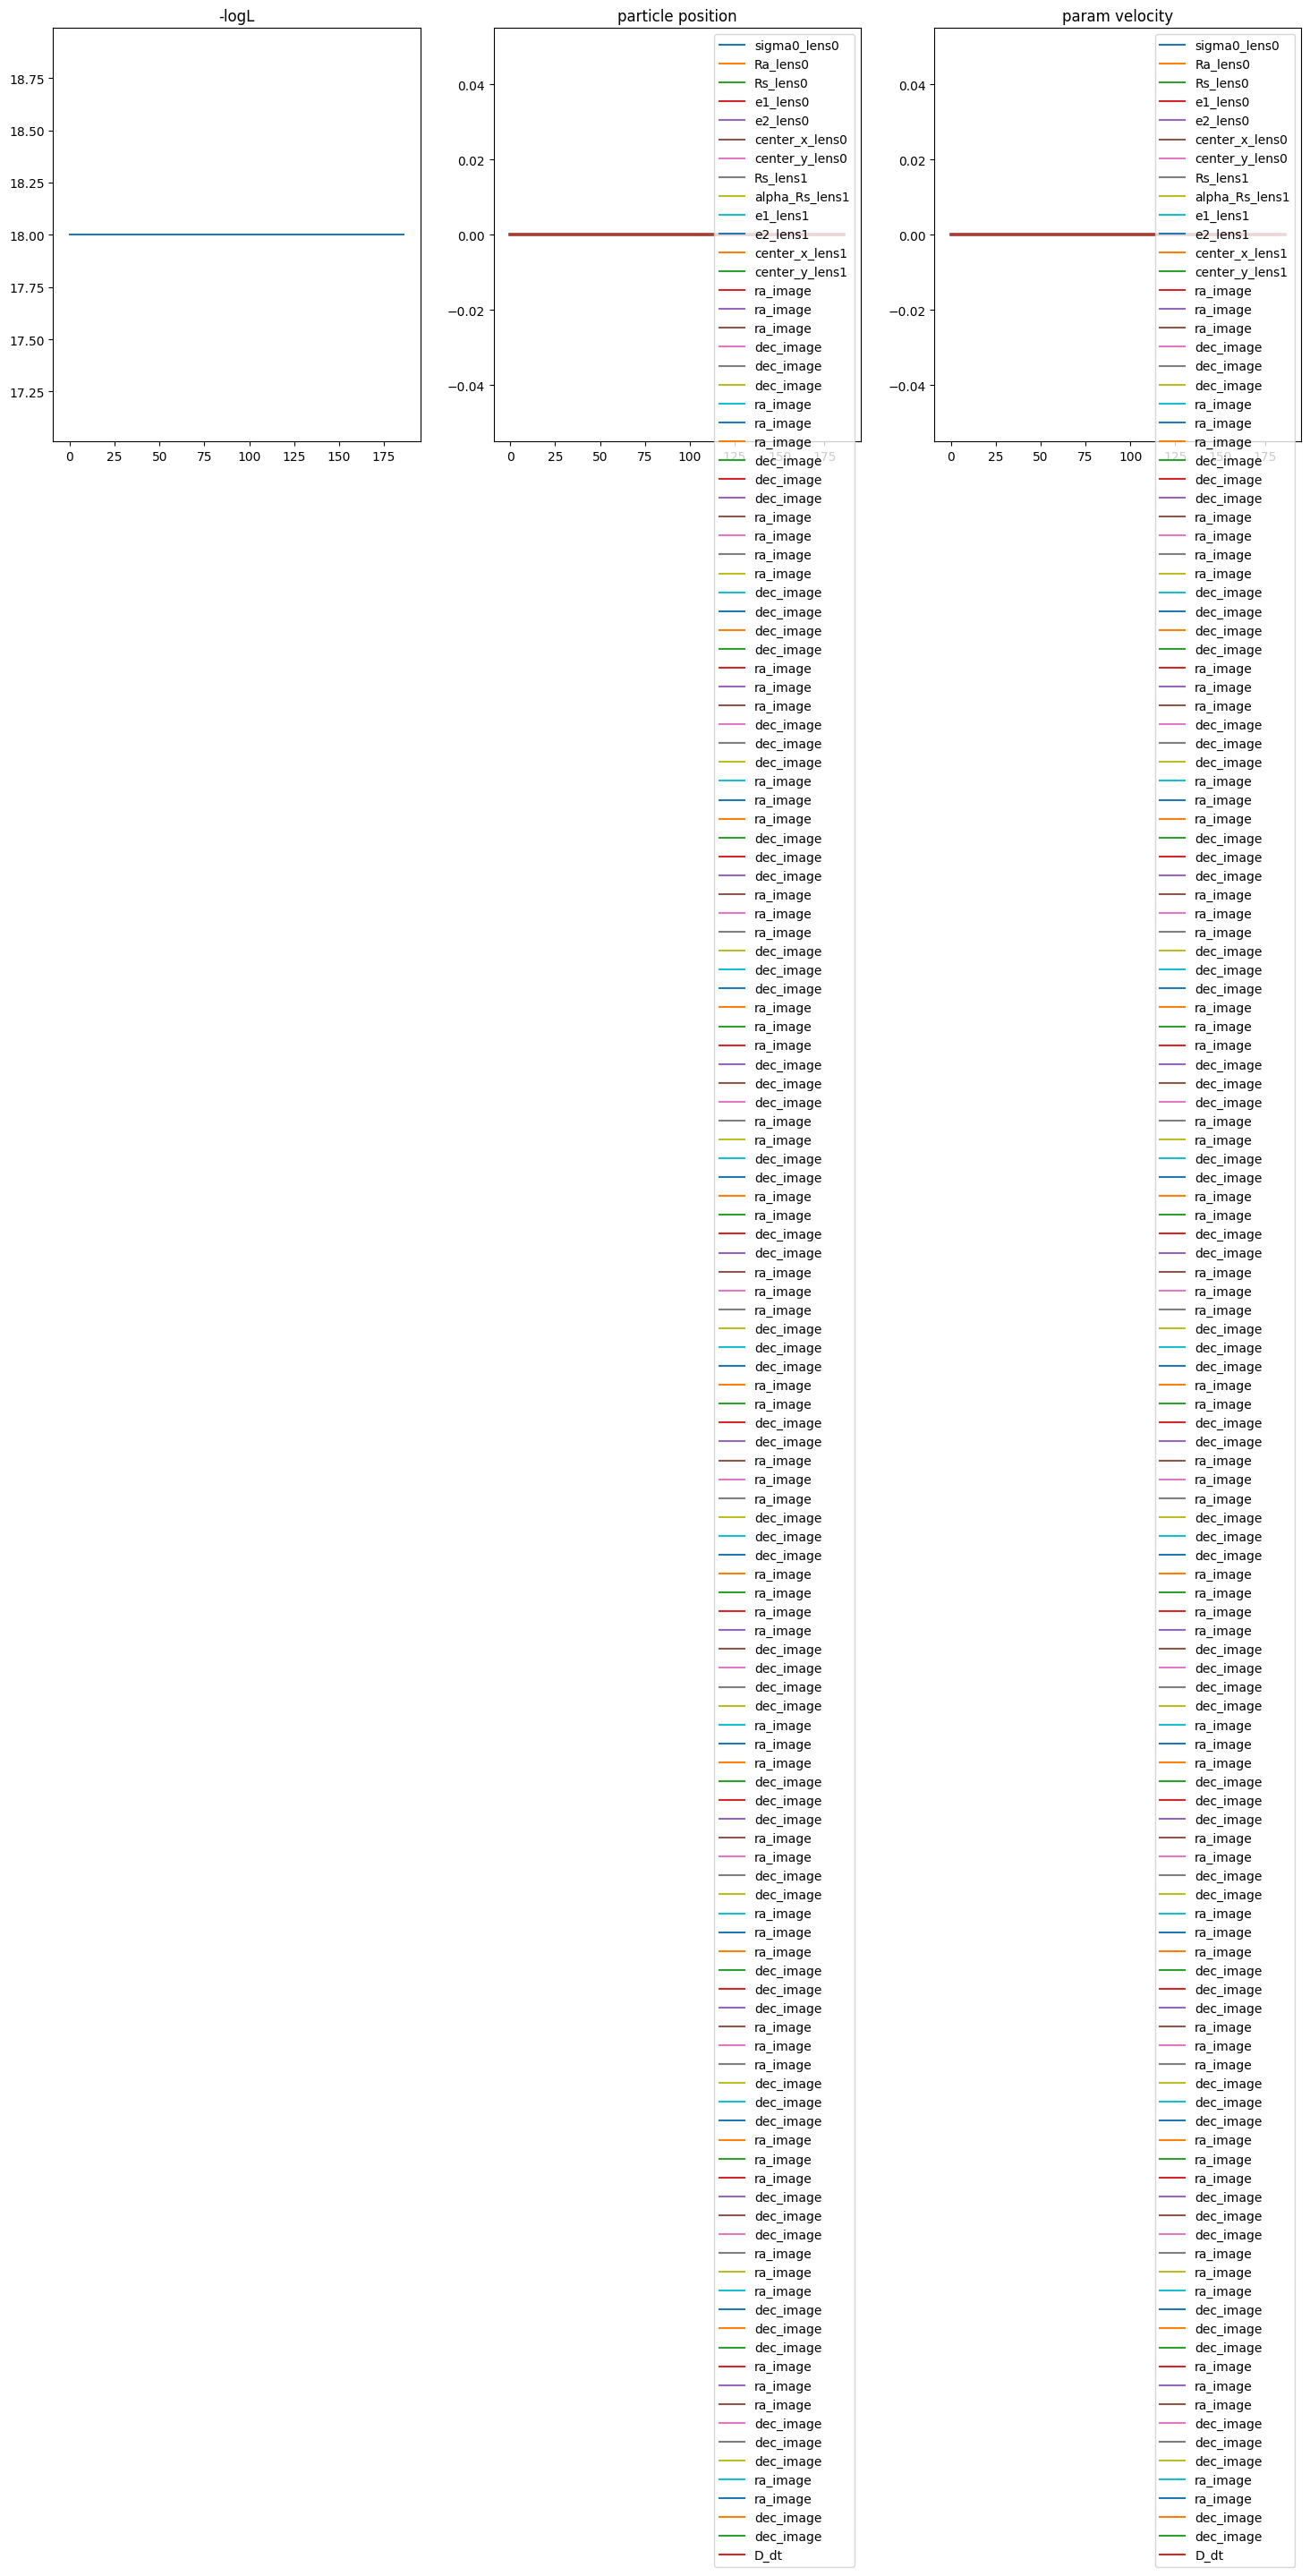

<Figure size 640x480 with 0 Axes>

In [63]:
kwargs_result = fitting_seq.best_fit(bijective=True)
args_result = fitting_seq.param_class.kwargs2args(**kwargs_result)
logL = fitting_seq.likelihoodModule.logL(args_result, verbose=True)

from lenstronomy.Plots import chain_plot
for i in range(len(chain_list_pso)):
    chain_plot.plot_chain_list(chain_list_pso, i)

print("kwargs_results", kwargs_result)

## MCMC posterior sampling

In [64]:
#and now we run the MCMC
fitting_kwargs_list = [
    # ['MCMC', {'n_burn': 400, 'n_run': 600, 'walkerRatio': 10,'sigma_scale': 0.1}]
    ['MCMC', {'n_burn': 400, 'n_run': 600, 'walkerRatio': 10,'sigma_scale': 0.1}]
]
chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)

kwargs_result = fitting_seq.best_fit()

MCMC selected. Sampling with default option emcee.


  0%|          | 4/1000 [08:40<36:27:25, 131.77s/it]Traceback (most recent call last):
  File "C:\Users\earth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\emcee\ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\Sampling\likelihood.py", line 348, in logL
    return self.log_likelihood(kwargs_return, verbose=verbose)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\Sampling\likelihood.py", line 411, in log_likelihood
    logL_flux_ratios = self.flux_ratio_likelihood.logL(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\Sampling\Lik

emcee: Exception while calling your likelihood function:
  params: [ 1.50082330e+00  9.98945476e-01  1.69980657e+01  9.97899633e-02
  9.83790745e-03  9.78600233e-02 -9.06073079e-02  7.34729216e-01
  9.98881627e-01  8.04534848e-02  4.85919205e-05 -3.98651755e-03
 -6.82398271e-03 -9.99999992e+00 -9.99999995e+00 -9.99999979e+00
  9.99999976e+00 -4.18509644e-01 -9.99999984e+00 -9.99999987e+00
 -9.99999990e+00 -9.99999955e+00  9.99999967e+00 -1.75859472e+00
 -9.99999979e+00 -4.60045895e+00 -6.56859627e+00  2.02672859e+00
  4.71892071e+00  9.99999994e+00 -1.72080732e+00 -9.99999985e+00
 -3.99862622e-01  9.99999993e+00  9.99999997e+00  9.99999991e+00
 -9.99999982e+00  3.19087422e-01  9.99999991e+00  4.05188142e+00
  6.07775663e+00  7.95489852e+00  9.99999717e+00  6.98778694e+00
 -9.99999993e+00 -9.99999872e+00 -9.99999976e+00 -4.46560404e+00
  9.99999828e+00  5.89413526e+00 -9.99999990e+00  9.99999992e+00
  9.99999997e+00  9.99999998e+00  9.99999996e+00  9.99999989e+00
  9.99999991e+00  9.999

KeyboardInterrupt: 

(<Figure size 600x600 with 1 Axes>, <Axes: >)

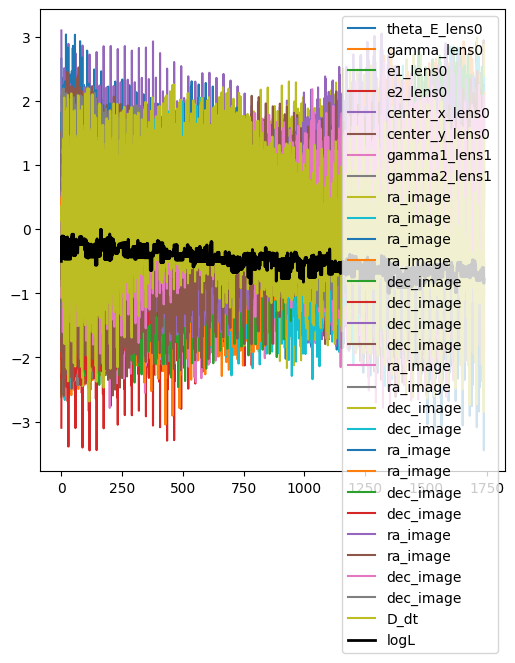

In [121]:
chain_plot.plot_chain_list(chain_list_mcmc)
## we want the logL (log likelihood) to stay fairly flat across the plot, that means its a decent guess.

## Post-processing the chains 

In [122]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list_mcmc[0]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
import lenstronomy.Util.param_util as param_util
# make instance of parameter class with given model options, constraints and fixed parameters
# this allows to recover the full parameters of all model components, not just the ones being sampled.

param = Param(kwargs_model, fixed_lens, kwargs_fixed_ps=fixed_ps, kwargs_fixed_special=fixed_special, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

lensModel = LensModel(kwargs_model['lens_model_list'])
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
print("parameter values: ", param)

number of non-linear parameters in the MCMC process:  29
parameters in order:  ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  174000
parameter values:  <lenstronomy.Sampling.parameters.Param object at 0x0000025E32C31490>


In [123]:
labels_new = [r"$\theta_E$", r"$\gamma$", r"$\phi_{lens}$", r"$q$", r"$\phi_{ext}$", r"$\gamma_{ext}$"]

lenstronomy_clusters_functions.clusters_functions.real_image_pos_labels(num_sources, x_imgs, labels_new, label_lists, image_position_likelihood=False)
lenstronomy_clusters_functions.clusters_functions.flux_ratio_labels(num_sources, x_imgs, labels_new, label_lists, flux_ratio_likelihood=False)
lenstronomy_clusters_functions.clusters_functions.source_size_labels(kwargs_constraints, labels_new, special_params=special_params)
lenstronomy_clusters_functions.clusters_functions.time_delay_labels(labels_new, time_delay_likelihood=True)
    
print(labels_new)

['$\\theta_E$', '$\\gamma$', '$\\phi_{lens}$', '$q$', '$\\phi_{ext}$', '$\\gamma_{ext}$', '$D_{dt}$']


In [124]:
# mcmc_new_list = samples2posterior_plot(samples=samples_mcmc, mcmc_list=mcmc_new_list, param_class=param, kwargs_constraints=kwargs_constraints, with_flux_ratios=True)

new_chain = []
mcmc_new_list_04_constz = []

mcmc_new_list_04_constz = lenstronomy_clusters_functions.clusters_functions.samples2posterior_plot(samples=samples_mcmc, mcmc_list=mcmc_new_list_04_constz, param_class=param, kwargs_constraints=kwargs_constraints, special_params=special_params, image_position_likelihood=False, with_flux_ratios=False, time_delay_likelihood=True)

In [125]:
np.save('mcmc_new_list_04_constz', mcmc_new_list_04_constz)
print(mcmc_new_list_04_constz[0])

[ 1.01070744e+00  2.02530053e+00 -9.92311772e-01  9.20793612e-01
 -2.25467431e-02  8.81616398e-02  3.23129385e+03]


In [126]:
print(np.shape(mcmc_new_list_04_constz))
print(len(labels_new))

(174000, 7)
7


In [127]:
# import code for legend on corner plot
import matplotlib.lines as mlines

purple_line = mlines.Line2D([], [], color='purple', label=str(num_sources_data)+" Sources, varied z")
blue_line = mlines.Line2D([], [], color='blue', label='4 Sources, const z')
red_line = mlines.Line2D([], [], color='red', label='5 Sources')
gray_line = mlines.Line2D([], [], color='gray', label='6 Sources')
black_line = mlines.Line2D([], [], color='black', label='7 Sources')

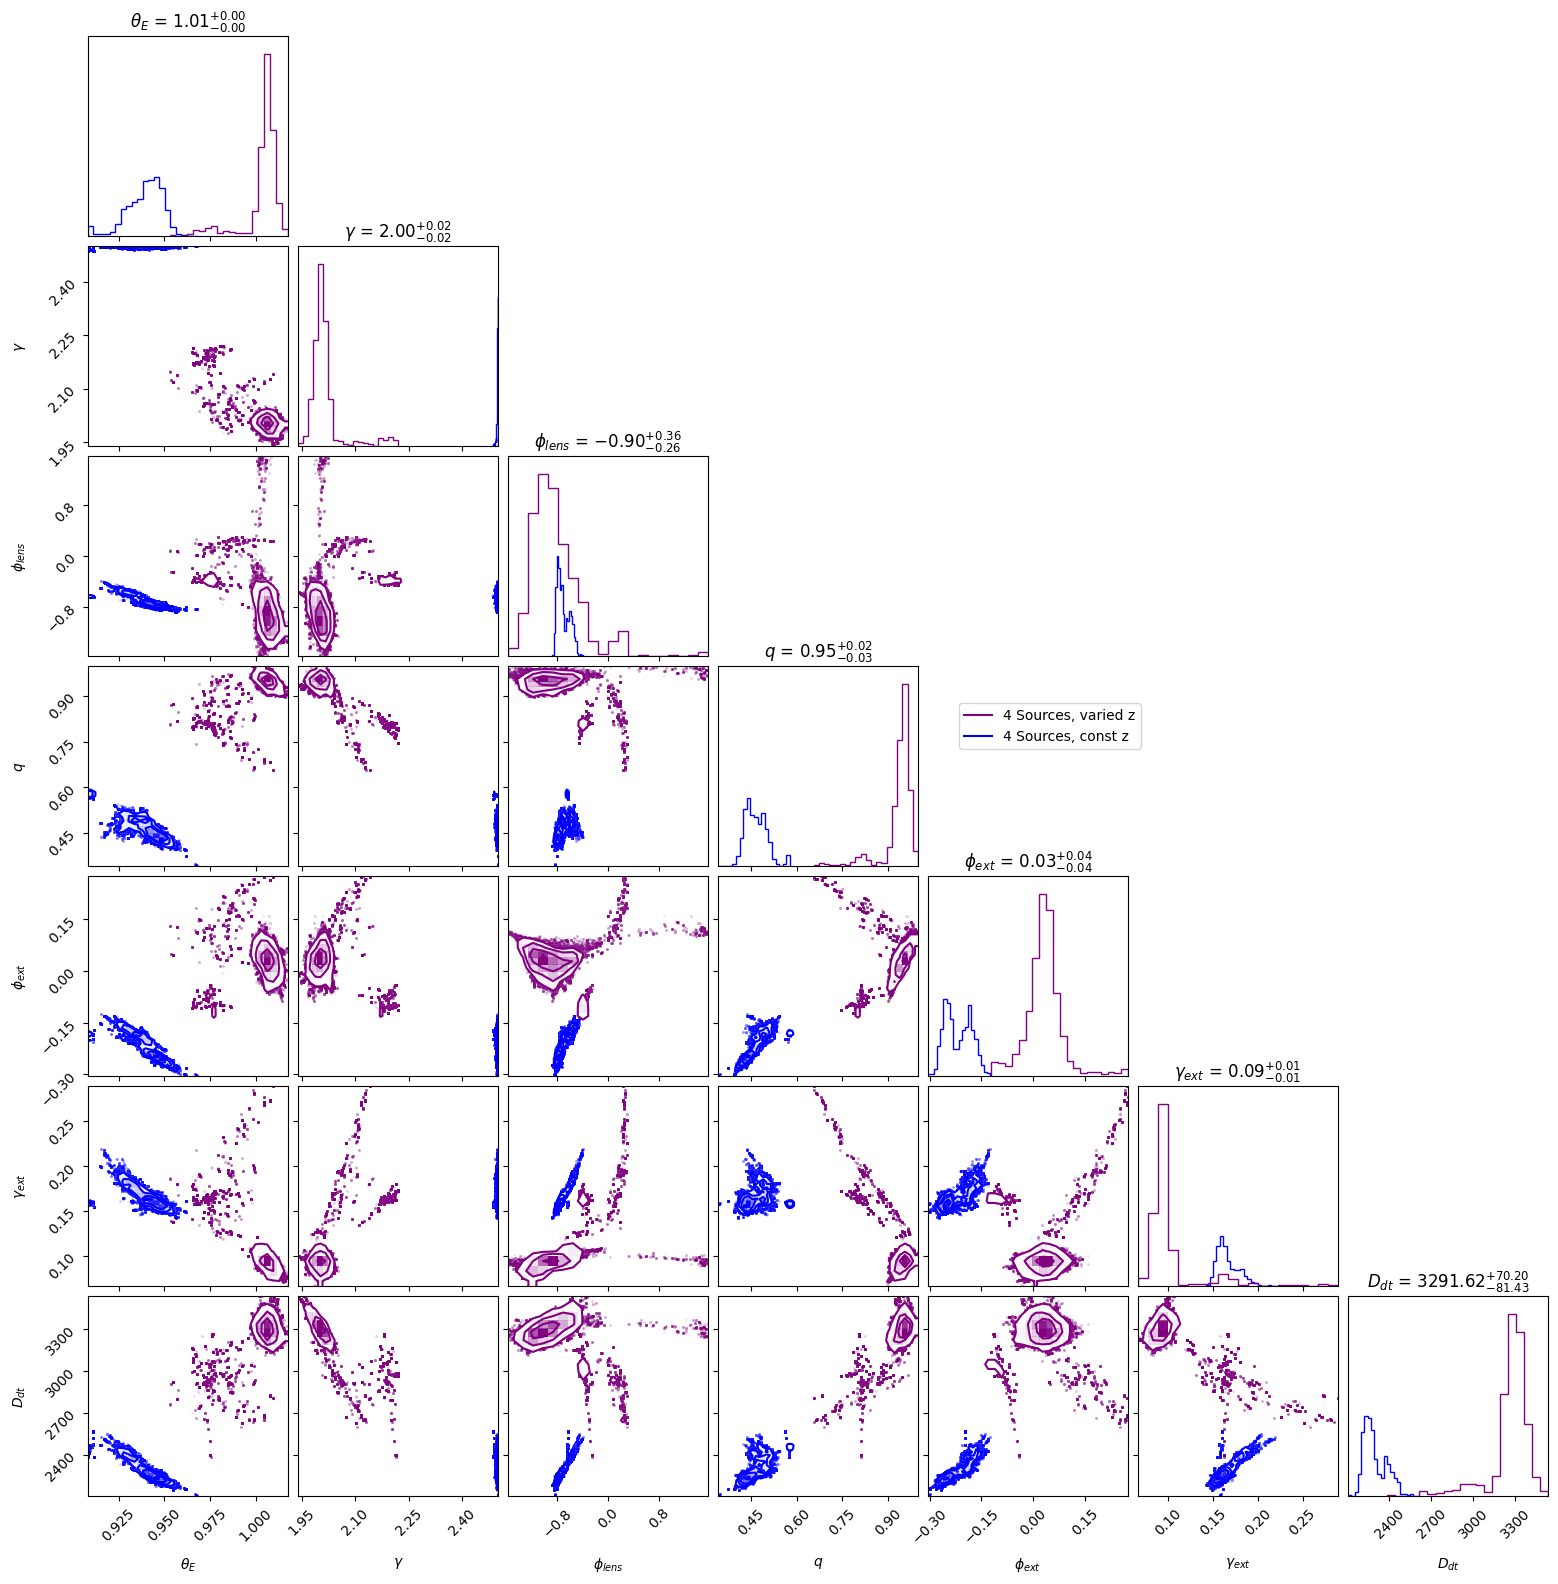

In [128]:
mcmc_new_list_04_variedz = np.load('mcmc_new_list_04_variedz.npy')
# mcmc_new_list_05 = np.load('mcmc_new_list_05.npy')
# mcmc_new_list_06 = np.load('mcmc_new_list_06.npy')
# mcmc_new_list_07 = np.load('mcmc_new_list_07.npy')
# # samples8 = np.array(mcmc_new_list_08[135000:270000])
# samples7 = np.array(mcmc_new_list_07[123000:246000])
# samples6 = np.array(mcmc_new_list_06[111000:222000])
# samples5 = np.array(mcmc_new_list_05[87000:198000])
samples_variedz = np.array(mcmc_new_list_04_variedz[87000:174000])
samples_constz = np.array(mcmc_new_list_04_constz[75000:150000])

# figure_last = corner.corner(samples5, fig=corner.corner(samples4), labels=labels_new, color='gray', show_titles=False) #, labels=labels_new, color='gray', show_titles=True)
# figure_1 = corner.corner(samples6, fig=figure_last, labels=labels_new, color='red', show_titles=False) #, labels=labels_new, color='gray', show_titles=True)
figure = corner.corner(samples_variedz, labels=labels_new, color='blue', show_titles=False) # fig=plot should put the one with reduced data and the full one on top of each other... reduced = blue, original = gray
plot = corner.corner(samples_constz, fig=figure, labels=labels_new, color='purple', truth_color = 'orange', show_titles=True)
                    #  truths=[kwargs_lens[0]['theta_E'], gamma1, phi, q, 0.1, gamma2, lensCosmo.ddt], truth_color='orange', show_titles=True)
# theta_E = 1.0
# gamma = 2.0
# phi_lens = -0.7
# q = 0.9
# phi_ext = 0.1
# gamma_ext = 0.1
# Ddt = lensCosmo.ddt
#plot = corner.corner(samples8, fig=figure, labels=labels_new, color='purple', show_titles=False, truths=[theta_, gamma, phi_lens, q, phi_ext, gamma_ext, d_dt], truth_color='orange')


plt.legend(handles=[purple_line, blue_line], bbox_to_anchor=(-2, 4., 1., .0), loc=1)


In [129]:
# input truth time-delay distance [Mpc]
lensCosmo.ddt

np.float64(3329.6653609254795)

In [130]:
theta_e = 1.0
gamma = 2.0
phi_lens = -0.7
q = 0.9
phi_ext = 0.1
gamma_ext = 0.1
Ddt = lensCosmo.ddt